In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
import os
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
nueva_ruta ='/media/erick/TOSHIBA EXT/resultados_weak/mu_1'

In [3]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
# nb = int(os.getenv('nb'))
nb = 5

os.chdir(nueva_ruta)

In [4]:
def power_spectrum(field_type, t, block):
    """
    Calcula el espectro de potencia 2D en el espacio de Fourier y lo guarda normalizado.
    """
    field_file = f"matrix_{field_type}_{t:.3f}_nb_{block}.txt"
    field = np.loadtxt(field_file, float)
    # field = np.rot90(field, k=1, axes=(0, 1))  # Rotación según necesidad

    # Transformada de Fourier
    fft_field = np.fft.fft2(field)
    fft_field = np.fft.fftshift(fft_field)
    fft_field = np.abs(fft_field)

    # Eliminar la frecuencia cero (componente DC)
    # max_fft = np.where(fft_field == fft_field.max())
    # fft_field[max_fft[0][0], max_fft[1][0]] = 0

    # Normalización: Dividir por la suma total para asegurar consistencia
    fft_field /= np.sum(fft_field)

    # Guardar el espectro de potencia normalizado
    dft_file = f"matrix_{field_type}_dft_{t:.3f}_nb_{block}.txt"
    np.savetxt(dft_file, fft_field, delimiter="\t")
    return field_file, dft_file

In [5]:
def plot_fft(dft_field_c, dft_field_s, dft_field_i, t, save_images, block): 

    dft_field_c = np.loadtxt(dft_field_c, float)
    dft_field_c[dft_field_c == 0.0] = np.nan
    dft_field_s = np.loadtxt(dft_field_s, float)
    dft_field_s[dft_field_s == 0.0] = np.nan
    dft_field_i = np.loadtxt(dft_field_i, float)
    dft_field_i[dft_field_i == 0.0] = np.nan   
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 3, 1)
    img1 = plt.imshow(dft_field_c, interpolation='bilinear')
    plt.title("$fft_c(t={})$".format("{:.3f}".format(t)))
    plt.colorbar(img1, fraction=0.046, pad=0.04)  # Ajusta fraction y pad
    
    plt.subplot(1, 3, 2)
    img2 = plt.imshow(dft_field_s, interpolation='bilinear')
    plt.title("$fft_s(t={})$".format("{:.3f}".format(t)))
    plt.colorbar(img2, fraction=0.046, pad=0.04)  # Ajusta fraction y pad
    
    plt.subplot(1, 3, 3)
    img3 = plt.imshow(dft_field_i, interpolation='bilinear')
    plt.title("$fft_i(t={})$".format("{:.3f}".format(t)))
    plt.colorbar(img3, fraction=0.046, pad=0.04)  # Ajusta fraction y pad
    
    if save_images == 'Y':
        plt.savefig(f'FFT_block_{block}_step_{t:.3f}.png')
        plt.show()
        pass
    else:
        plt.show()
        pass

In [14]:
for block in range(1, nb + 1):
    t = 0
    print("block=", block)
    while t <= T:
        # Generar los espectros de potencia
        field_c, dft_field_c = power_spectrum('c', t, block)
        field_s, dft_field_s = power_spectrum('s', t, block)
        field_i, dft_field_i = power_spectrum('i', t, block)

        # Cargar los datos de los espectros
        dft_field_c_data = np.loadtxt(dft_field_c, float)
        dft_field_s_data = np.loadtxt(dft_field_s, float)
        dft_field_i_data = np.loadtxt(dft_field_i, float)

        # Igualar a cero el valor máximo en cada espectro
        dft_field_c_data[np.unravel_index(np.argmax(dft_field_c_data), dft_field_c_data.shape)] = 0
        dft_field_s_data[np.unravel_index(np.argmax(dft_field_s_data), dft_field_s_data.shape)] = 0
        dft_field_i_data[np.unravel_index(np.argmax(dft_field_i_data), dft_field_i_data.shape)] = 0

        # Guardar los espectros modificados para graficar
        np.savetxt(dft_field_c, dft_field_c_data, delimiter="\t")
        np.savetxt(dft_field_s, dft_field_s_data, delimiter="\t")
        np.savetxt(dft_field_i, dft_field_i_data, delimiter="\t")

        # Graficar los espectros modificados
        #plot_fft(dft_field_c, dft_field_s, dft_field_i, t, save_images, block)

        # Incrementar el tiempo
        t += dt

block= 1
block= 2
block= 3
block= 4
block= 5


In [15]:
def dft_mean(field, end_step, end_blocks, dt):
    t0 = 0
    min_shape = None
    
    while t0 <= end_step:
        # print('step', t0)
        final_file = None
        
        for nb in range(1, end_blocks + 1):
            file_name = "matrix_" + field + "_dft_" + "{:.3f}".format(t0) + "_nb_" + str(nb) + ".txt"
            file_load = np.loadtxt(file_name, float)
            
            if final_file is None:
                final_file = file_load
                min_shape = file_load.shape
            else:
                min_shape = (min(min_shape[0], file_load.shape[0]), min(min_shape[1], file_load.shape[1]))
        
        # Redimensionar final_file y file_load a min_shape
        final_file_cropped = final_file[:min_shape[0], :min_shape[1]]
        final_file = np.zeros(min_shape)  # Re-inicializar final_file al tamaño mínimo
        
        for nb in range(1, end_blocks + 1):
            file_name = "matrix_" + field + "_dft_" + "{:.3f}".format(t0) + "_nb_" + str(nb) + ".txt"
            file_load = np.loadtxt(file_name, float)
            file_load_cropped = file_load[:min_shape[0], :min_shape[1]]
            final_file += file_load_cropped
        
        final_file = final_file / float(end_blocks)
        
        f_save = "FFT_" + field + "_" + "{:.3f}".format(t0) + ".txt"
        np.savetxt(f_save, final_file, delimiter="\t")
        
        plt.imshow(final_file, cmap=plt.cm.seismic)
        plt.title(f'Mean_fft_{field}_(t={t0:.3f})')
        plt.colorbar()
        if save_images == 'Y':
            plt.savefig(f'mean_fft_block_{field}_{nb}_step_{t0:.3f}.png')
            plt.show()
        else:
            plt.show()
        t0 += dt

In [16]:
def plot_correlations_matrix(start_step, end_step, dt):
    """
    Grafica las correlaciones normalizadas para cada paso en el tiempo.

    Parámetros:
    - start_step: Paso temporal inicial.
    - end_step: Paso temporal final.
    - dt: Incremento temporal entre pasos.
    """
    steps = np.arange(start_step, end_step + dt, dt)

    # Iterar sobre cada paso en el tiempo
    for step in steps:
        # Leer las correlaciones guardadas por correlation_2D
        corr_types = ["cc", "ss", "ii", "cs", "ci", "si"]
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Crear una cuadrícula para las correlaciones
        axes = axes.flatten()

        for idx, corr_type in enumerate(corr_types):
            file_name = f"matrix_corr_{corr_type}_{str(step)}.txt"
            corr_matrix = np.loadtxt(file_name, float)

            # Graficar la correlación
            im = axes[idx].imshow(corr_matrix, cmap='viridis', origin='lower')
            axes[idx].set_title(f'Correlation {corr_type} (t={step:.3f})')
            plt.colorbar(im, ax=axes[idx])

        plt.tight_layout()

        # Guardar o mostrar el gráfico
        # plt.savefig(f"correlation_plots_t_{step:.3f}.png", dpi=300)
        plt.show()  # Elimina esto si no quieres que se muestre el gráfico cada vez

In [17]:
def correlation_2D(step):
    """
    Calcula las correlaciones 2D normalizadas en el espacio de Fourier para cada paso dado,
    eliminando el valor de r=0 y normalizando con respecto al siguiente máximo.

    Args:
        step (float): Paso temporal actual.

    Saves:
        Archivos de correlaciones normalizadas para cada combinación de campos.
    """
    # Cargar espectros promedio de Fourier
    abs_c = f"FFT_c_{step:.3f}.txt"
    abs_s = f"FFT_s_{step:.3f}.txt"
    abs_i = f"FFT_i_{step:.3f}.txt"

    mod_c = np.loadtxt(abs_c, float)
    mod_s = np.loadtxt(abs_s, float)
    mod_i = np.loadtxt(abs_i, float)

    # Función para eliminar r=0 y normalizar con respecto al siguiente máximo
    def remove_r0_and_normalize(matrix):
        # Identificar el centro de la matriz (r=0)
        center = tuple(np.array(matrix.shape) // 2)
        # Eliminar el valor de r=0
        matrix[center] = 0
        # Normalizar respecto al siguiente máximo
        new_max = matrix.max()
        if new_max != 0:
            matrix /= new_max
        else:
            print("Advertencia: El nuevo máximo es cero. No se puede normalizar.")
        return matrix

    # Procesar cada espectro
    norm_c = remove_r0_and_normalize(mod_c)
    norm_s = remove_r0_and_normalize(mod_s)
    norm_i = remove_r0_and_normalize(mod_i)

    # Calcular correlaciones cruzadas
    cs_corr = norm_c * norm_s
    ci_corr = norm_c * norm_i
    si_corr = norm_s * norm_i

    # Guardar todas las correlaciones normalizadas
    def save_corr(filename, matrix):
        np.savetxt(filename, matrix, delimiter="\t")

    save_corr(f"matrix_corr_cc_{step:.3f}.txt", norm_c)
    save_corr(f"matrix_corr_ss_{step:.3f}.txt", norm_s)
    save_corr(f"matrix_corr_ii_{step:.3f}.txt", norm_i)
    save_corr(f"matrix_corr_cs_{step:.3f}.txt", cs_corr)
    save_corr(f"matrix_corr_ci_{step:.3f}.txt", ci_corr)
    save_corr(f"matrix_corr_si_{step:.3f}.txt", si_corr)

    print(f"Correlaciones 2D guardadas para el paso {step:.3f}.")


In [ ]:
dft_mean('c', T, nb, dt)
dft_mean('s', T, nb, dt)
dft_mean('i', T, nb, dt)

In [ ]:
t = 0
while t < T:
    correlation_2D(t)
    t += dt

In [37]:
def radial_average(matrix, normalize=True):
    """
    Calcula el promedio radial de una matriz 2D, eliminando el valor de r=0
    y normalizando con respecto al siguiente valor máximo.

    Args:
        matrix (np.array): Matriz 2D de la cual se calcula el promedio radial.
        normalize (bool): Si True, normaliza el promedio radial con respecto al valor máximo después de eliminar r=0.

    Returns:
        tuple: 
            - r_bins (np.array): Distancias radiales desde el centro.
            - radial_avg (np.array): Valores promedio en cada distancia radial.
    """
    # Obtener dimensiones de la matriz y el centro
    ny, nx = matrix.shape
    center_y, center_x = ny // 2, nx // 2

    # Crear una matriz de coordenadas radiales
    y, x = np.indices((ny, nx))
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    r = r.astype(int)

    # Calcular promedio radial
    r_max = r.max() + 1
    radial_sum = np.bincount(r.ravel(), weights=matrix.ravel())
    radial_count = np.bincount(r.ravel())
    radial_avg = radial_sum / radial_count

    # Crear los valores radiales
    r_bins = np.arange(r_max)

    # Eliminar el valor correspondiente a r=0
    radial_avg[0] = 0

    # Normalizar con respecto al siguiente máximo si se solicita
    if normalize:
        next_max = radial_avg[1:].max()  # Máximo después de r=0
        if next_max != 0:
            radial_avg /= next_max
        else:
            print("Advertencia: El siguiente máximo después de r=0 es cero. No se puede normalizar.")

    return r_bins, radial_avg

In [38]:
def get_radial_average_over_time(start_step, end_step, dt, corr_types=["cc", "ss", "ii", "cs", "ci", "si"]):
    """
    Calcula y grafica el promedio circular de correlaciones para cada paso en el tiempo,
    excluyendo el primer valor (r = 0).

    Parámetros:
    - start_step: Paso temporal inicial.
    - end_step: Paso temporal final.
    - dt: Incremento temporal entre pasos.
    - corr_types: Lista de tipos de correlaciones a procesar.
    """
    steps = np.arange(start_step, end_step + dt, dt)

    for step in steps:
        for corr_type in corr_types:
            # Cargar la matriz de correlación
            file_name = f"matrix_corr_{corr_type}_{step:.3f}.txt"
            matrix = np.loadtxt(file_name, float)

            # Calcular promedio circular
            r_bins, radial_avg = radial_average(matrix)

            # Excluir el primer valor (r = 0)
            r_bins = r_bins[1:]
            radial_avg = radial_avg[1:]

            # Guardar r_bins y radial_avg en un solo archivo
            combined_file = f"corr_data_{corr_type}_{step:.3f}.txt"
            combined_data = np.column_stack((r_bins, radial_avg))
            np.savetxt(combined_file, combined_data, delimiter="\t", header="r_bins\tradial_avg")
            print(f"Guardado: {combined_file}")


In [39]:
def load_and_plot_radial_data(start_step, end_step, dt, corr_types=["cc", "ss", "ii", "cs", "ci", "si"], num_points=500):
    """
    Carga, interpola y grafica los datos radiales guardados para cada paso en el tiempo,
    incluyendo la longitud de correlación (valor en el que radial_avg = 0.5).

    Parámetros:
    - start_step: Paso temporal inicial.
    - end_step: Paso temporal final.
    - dt: Incremento temporal entre pasos.
    - corr_types: Lista de tipos de correlaciones a procesar.
    - num_points: Número de puntos para la interpolación.
    """
    steps = np.arange(start_step, end_step + dt, dt)
    
    
    for step in steps:
        fig, ax = plt.subplots(figsize=(10, 6))

        for corr_type in corr_types:
            # Construir el nombre del archivo
            file_name = f"corr_data_{corr_type}_{step:.3f}.txt"

            # Cargar los datos radiales
            try:
                data = np.loadtxt(file_name, delimiter="\t", skiprows=1)
                r_bins, radial_avg = data[:, 0], data[:, 1]

                # Interpolación de los datos
                interpolator = interp1d(r_bins, radial_avg, kind='cubic', fill_value="extrapolate")
                r_fine = np.linspace(r_bins.min(), r_bins.max(), num_points)
                radial_avg_fine = interpolator(r_fine)

                # Encontrar la longitud de correlación (donde radial_avg = 0.5)
                try:
                    correlation_length_index = np.where(radial_avg_fine <= 0.5)[0][0]
                    correlation_length = r_fine[correlation_length_index]
                except IndexError:
                    correlation_length = None  # No se encontró un valor <= 0.5

                # Graficar datos interpolados
                ax.plot(r_fine, radial_avg_fine, label=f'{corr_type} (t={step:.3f})')

                # Marcar la longitud de correlación
                if correlation_length is not None:
                    ax.axvline(correlation_length, color='red', linestyle='--', label=f'xi ({corr_type}, t={step:.3f}) = {correlation_length:.2f}')
            except Exception as e:
                print(f"No se pudo cargar el archivo {file_name}: {e}")
                continue

        ax.set_title(f'Radial Average of Correlations (t={step:.3f})')
        ax.set_xlabel('Radial Distance (r)')
        ax.set_ylabel('Average Correlation')
        ax.legend()
        ax.grid(True)

        # Guardar o mostrar el gráfico
        plt.tight_layout()
        plt.savefig(f"radial_average_with_correlation_length_t_{step:.3f}.png", dpi=300)
        plt.show()

In [ ]:
get_radial_average_over_time(start_step=0, end_step=T-dt, dt=dt, corr_types=["cc","ss","ii","cs", "ci", "si"])

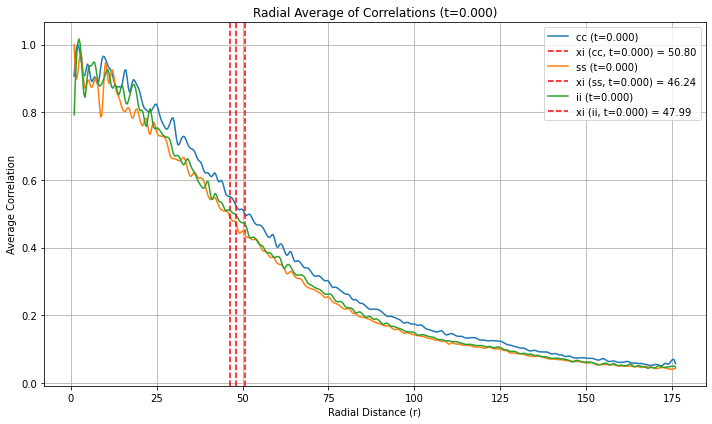

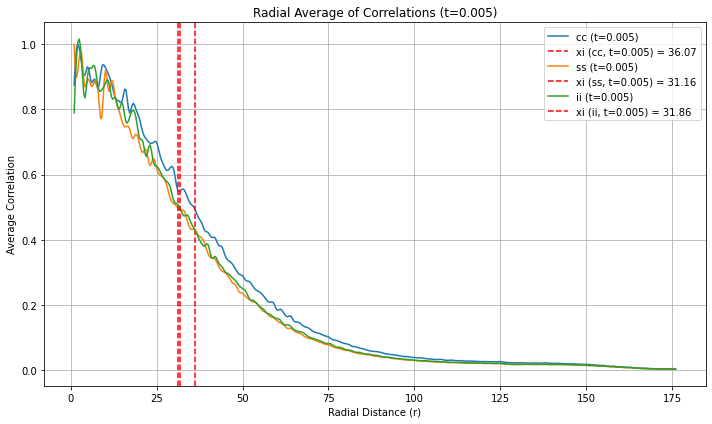

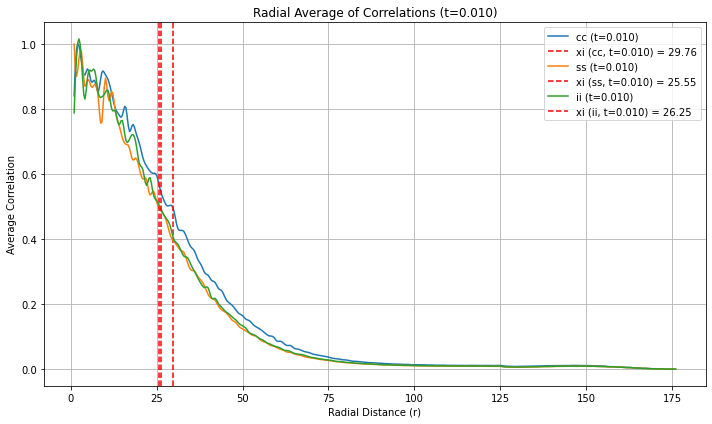

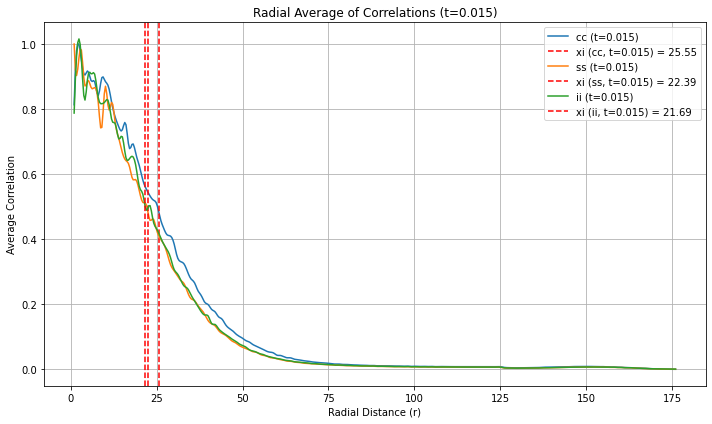

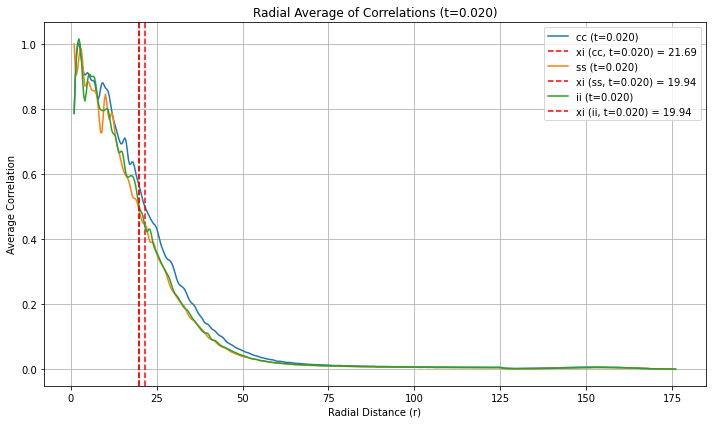

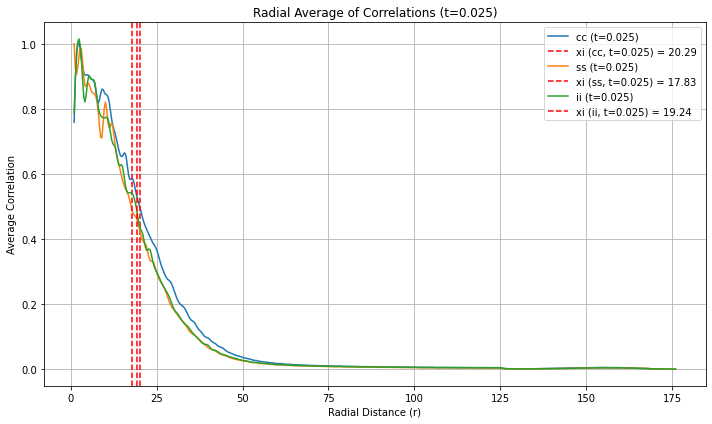

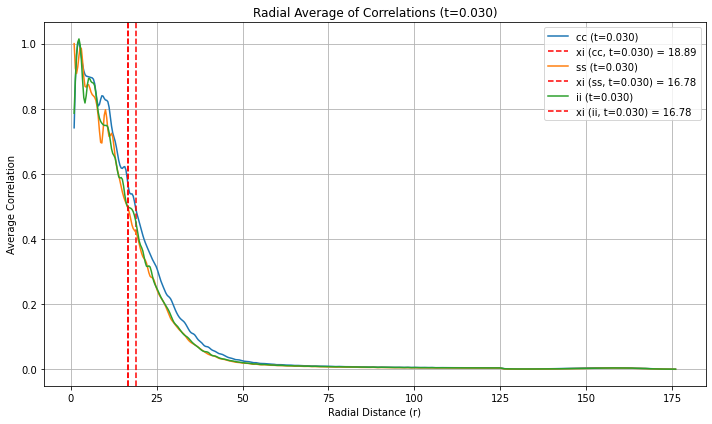

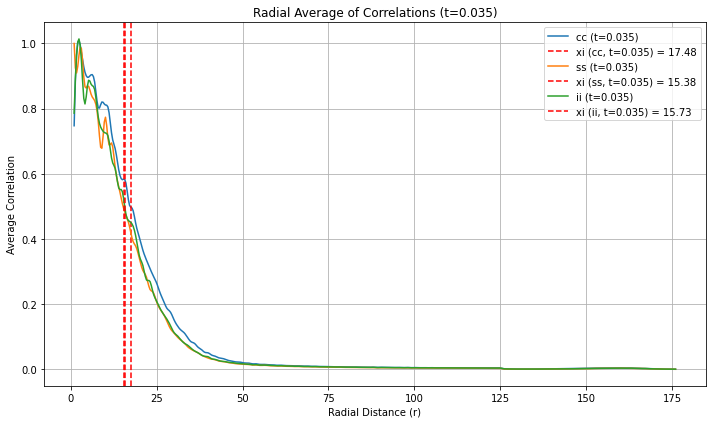

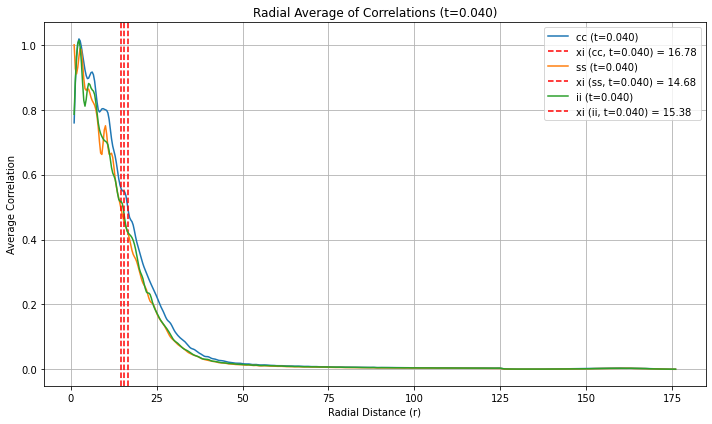

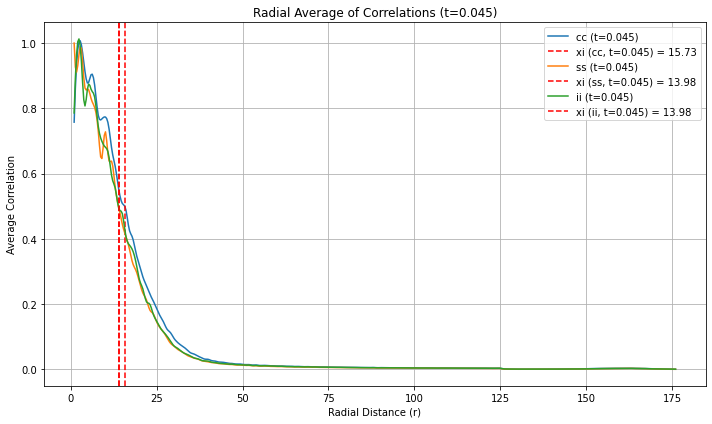

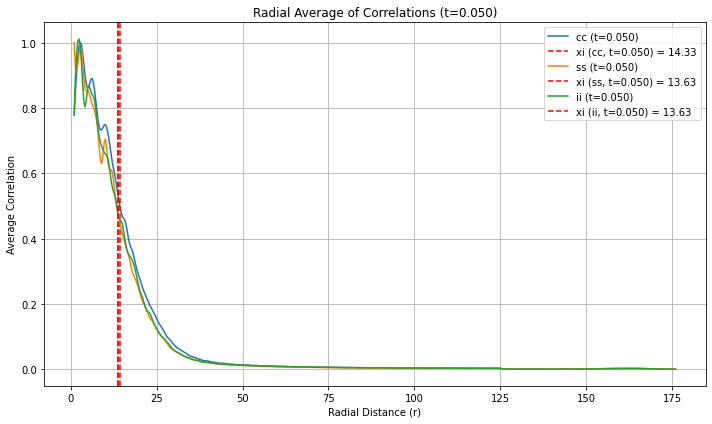

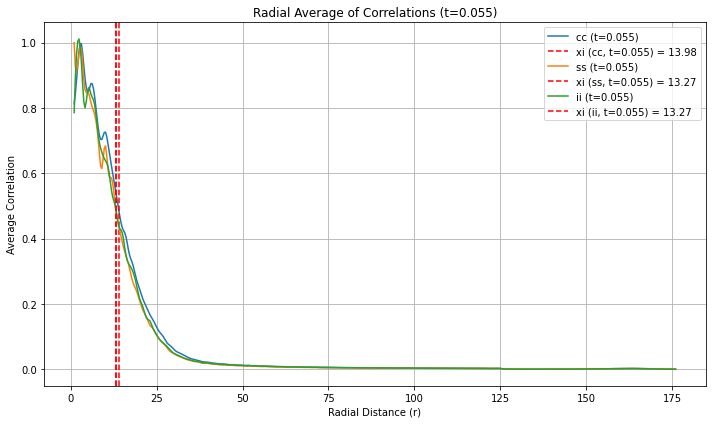

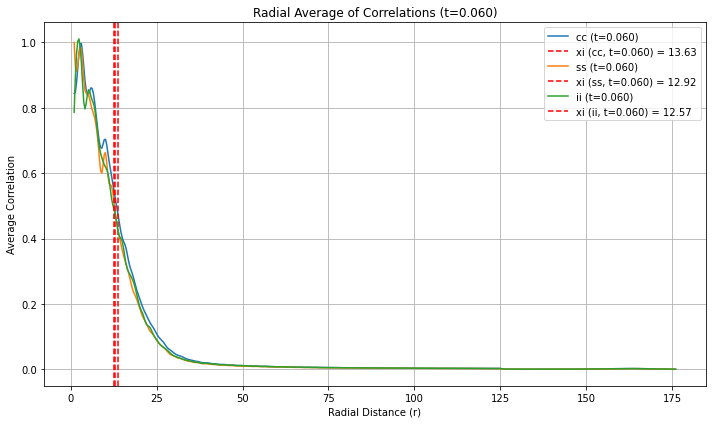

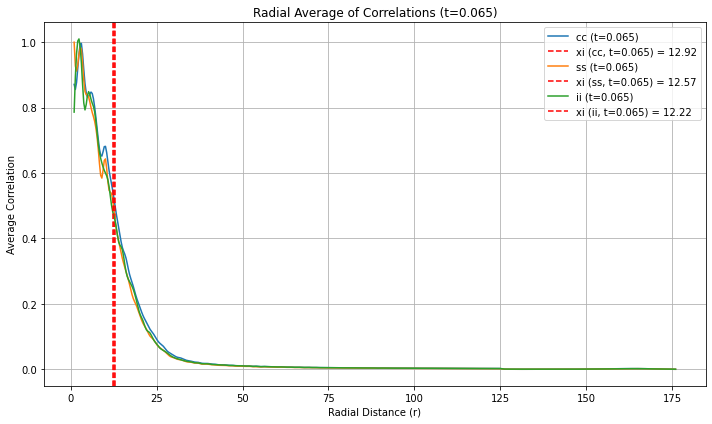

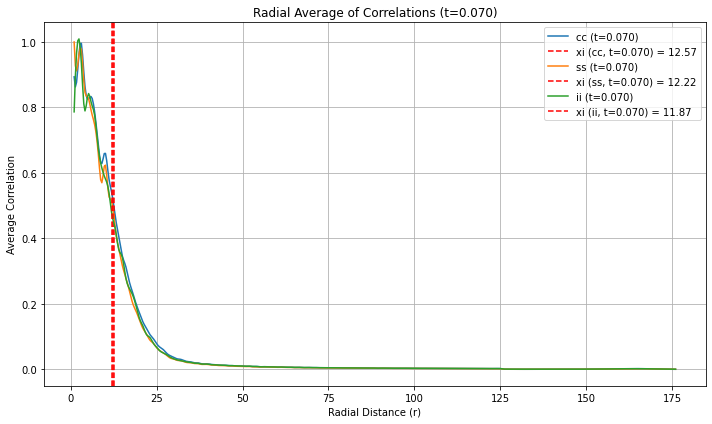

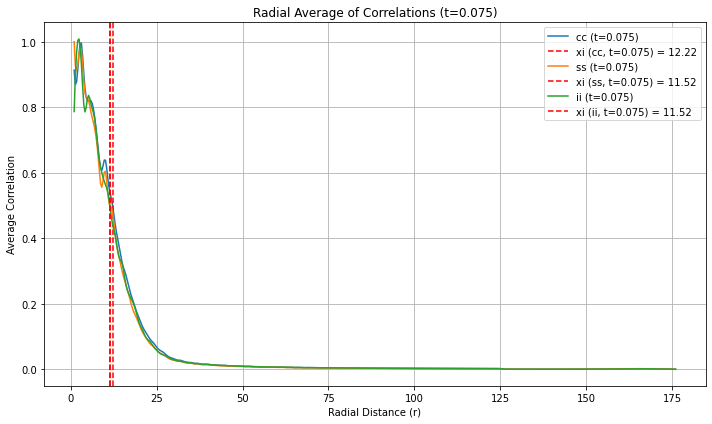

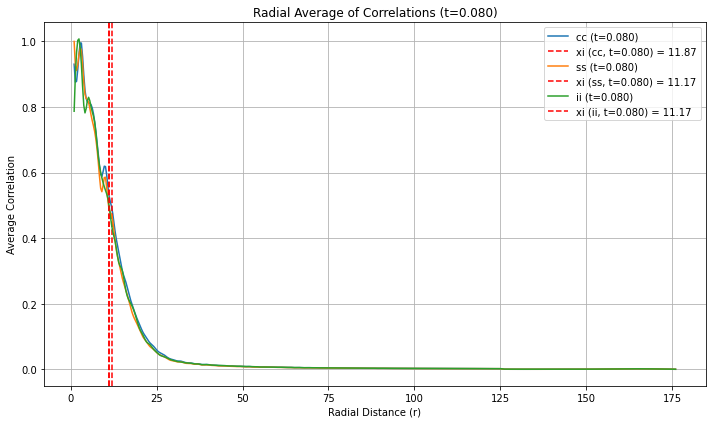

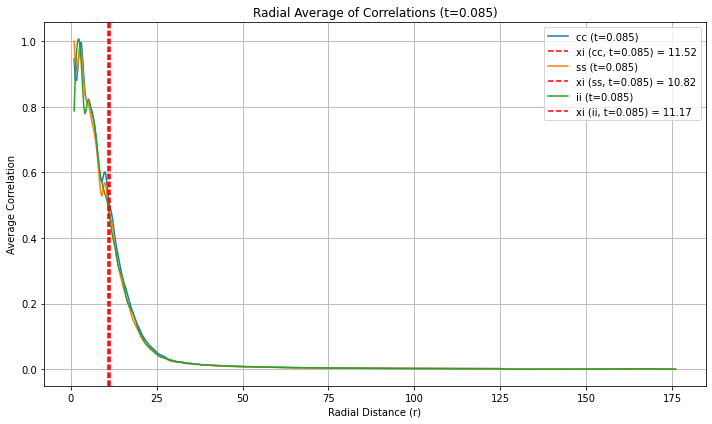

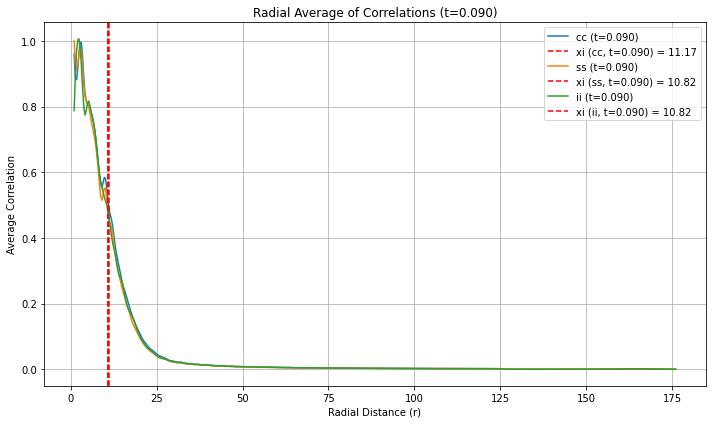

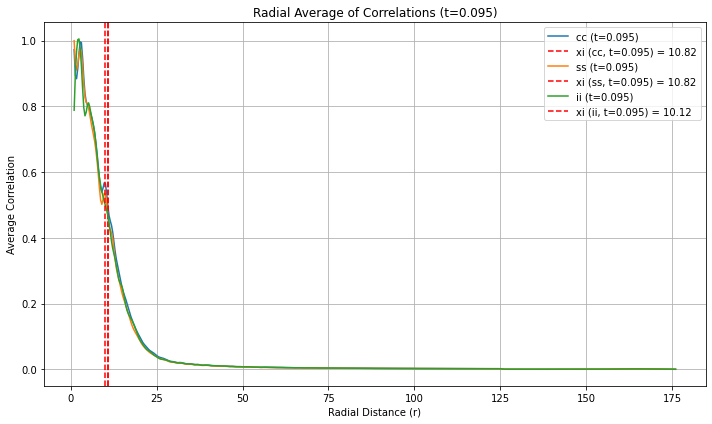

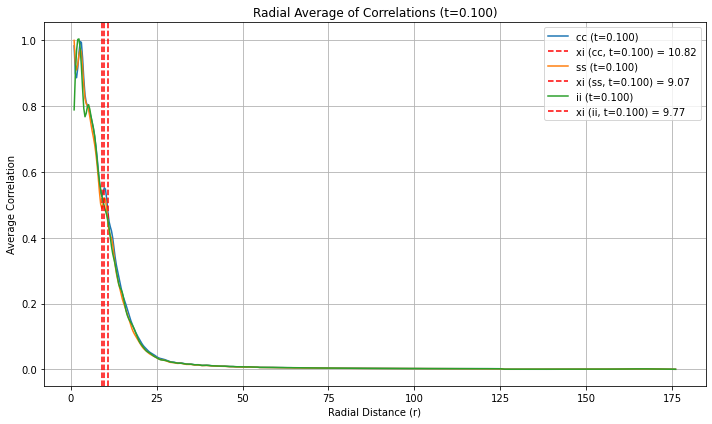

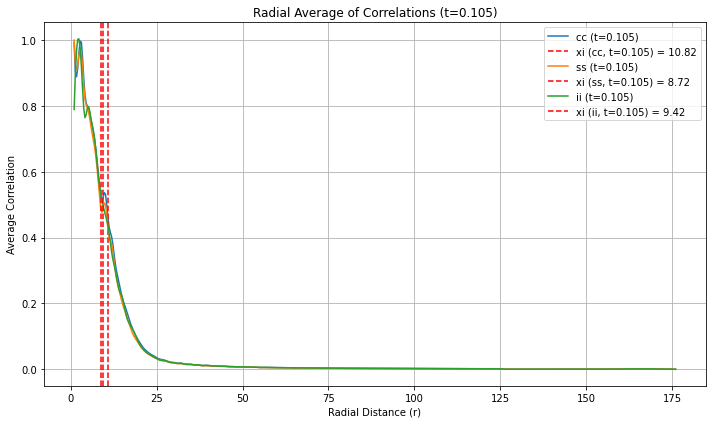

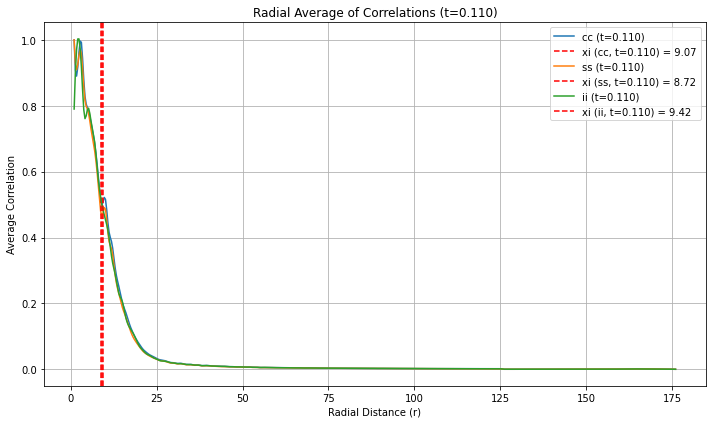

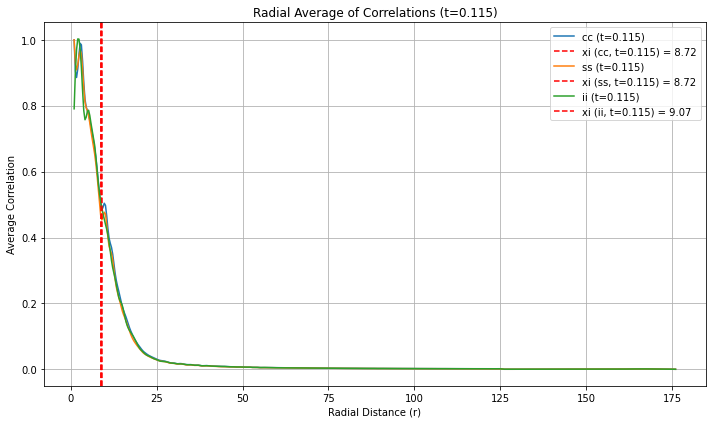

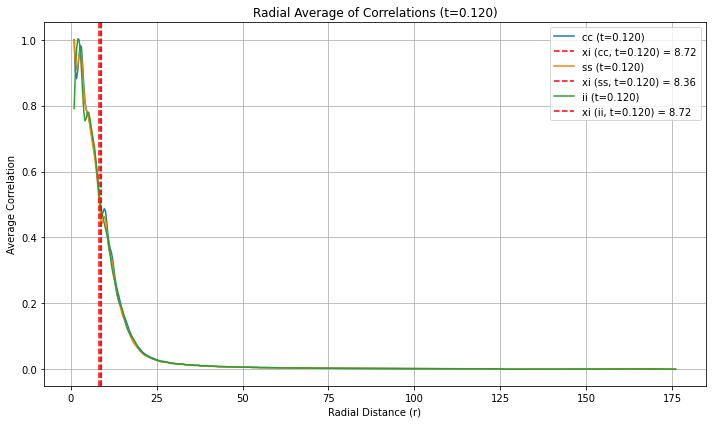

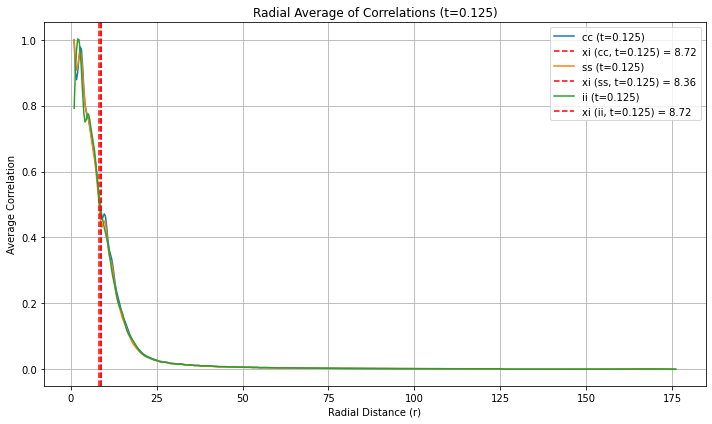

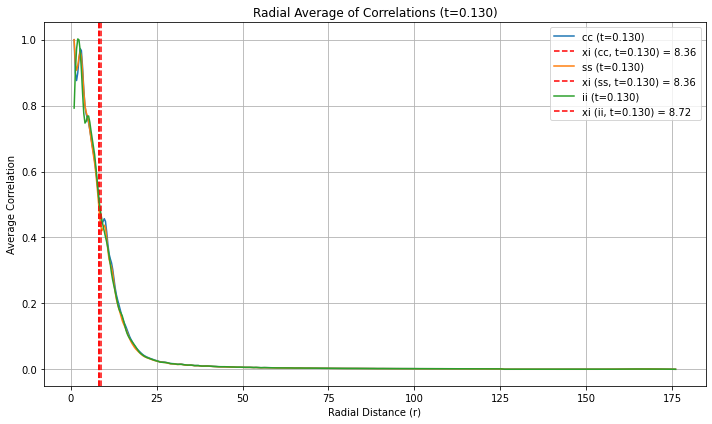

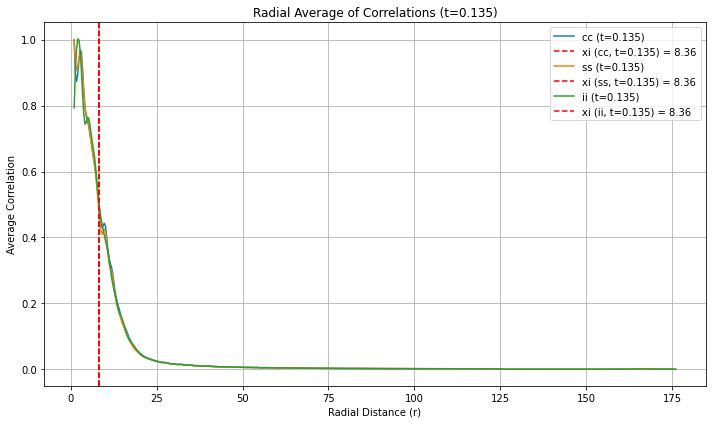

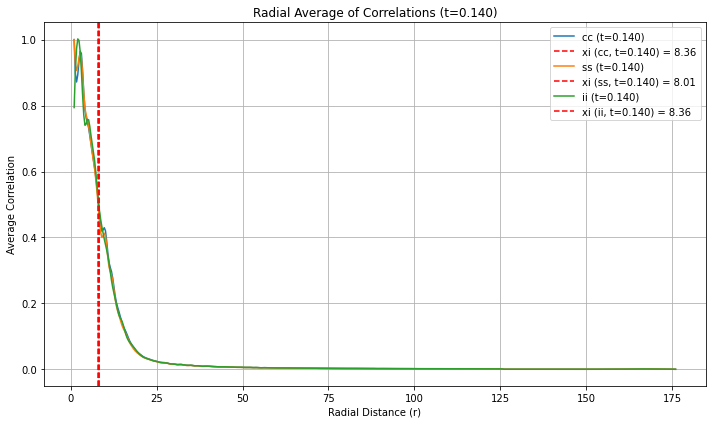

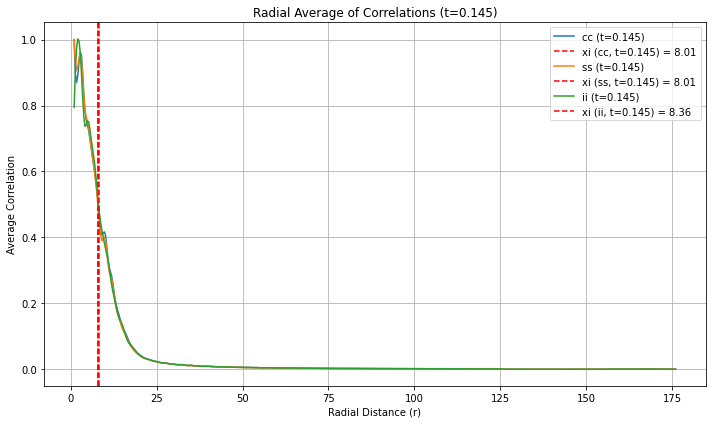

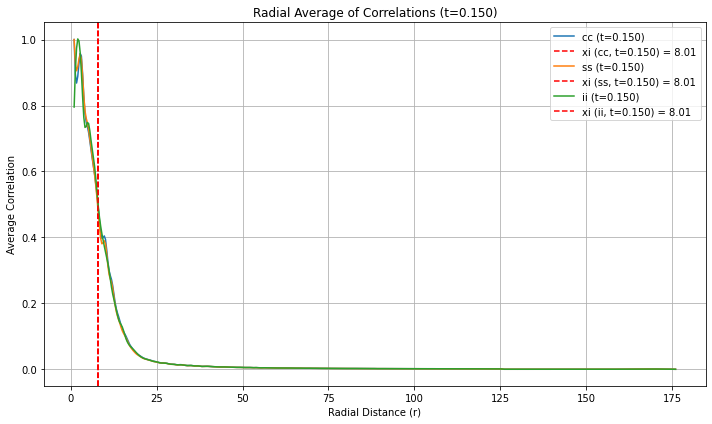

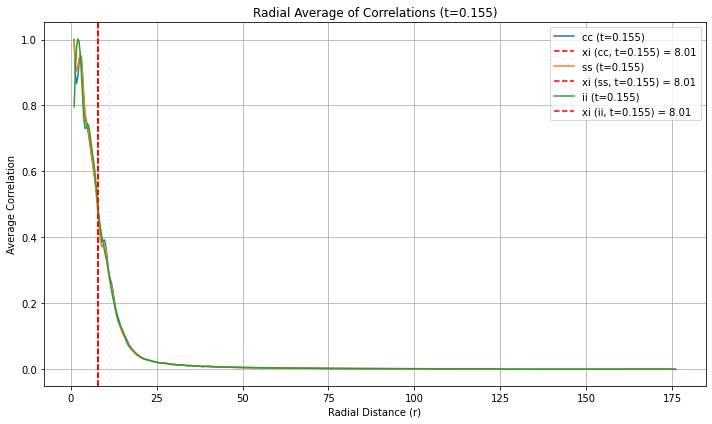

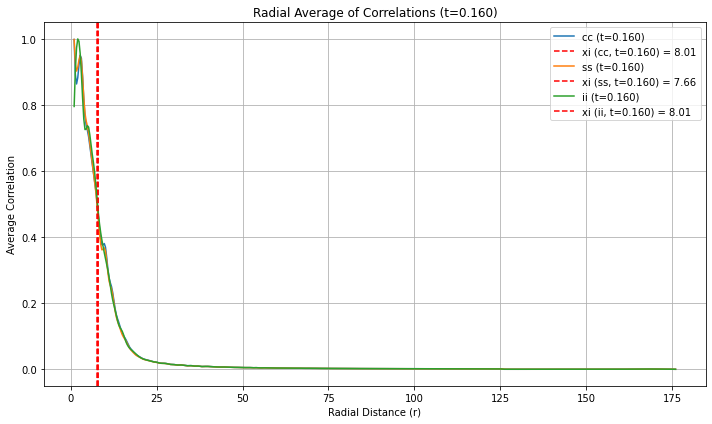

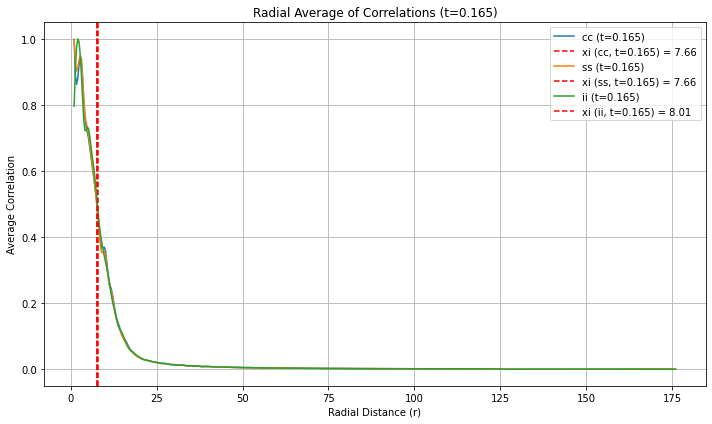

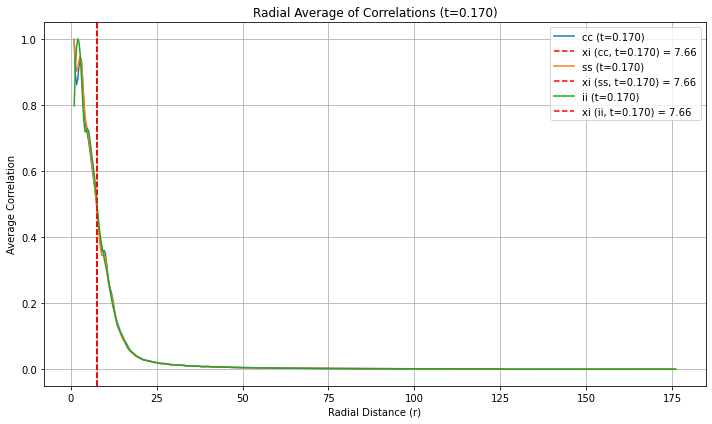

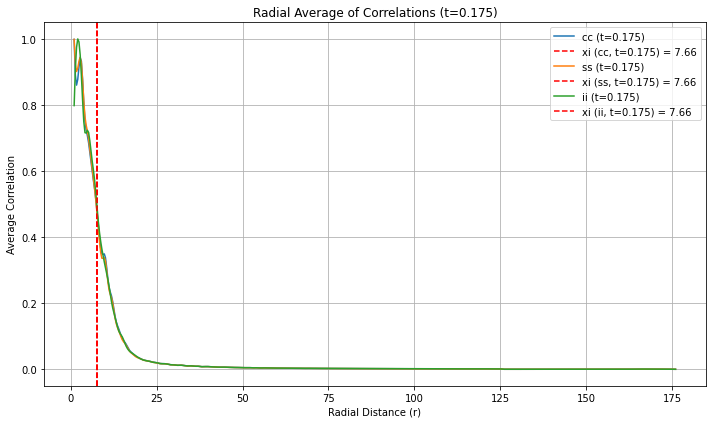

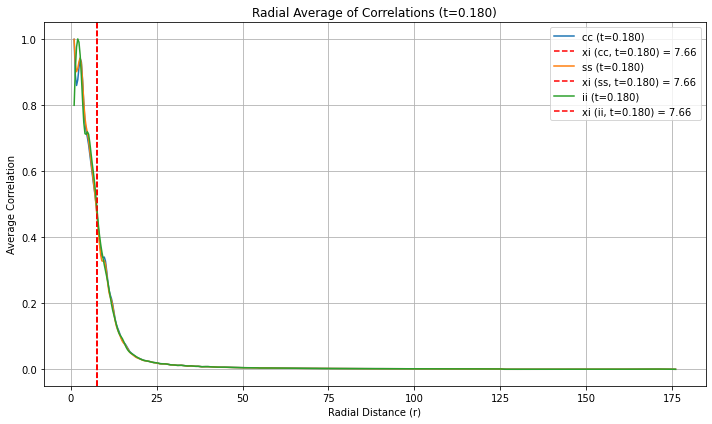

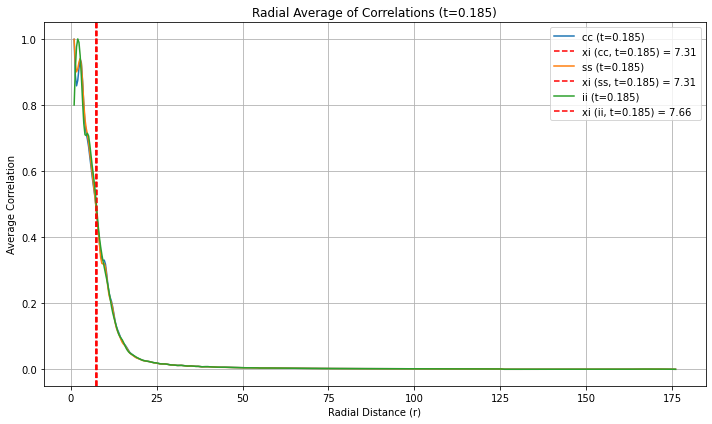

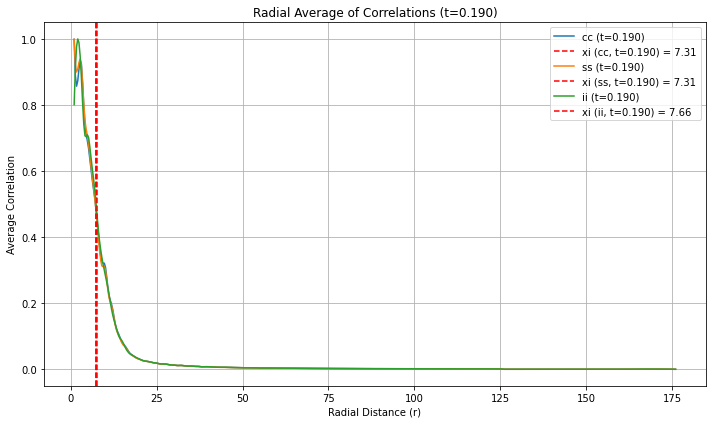

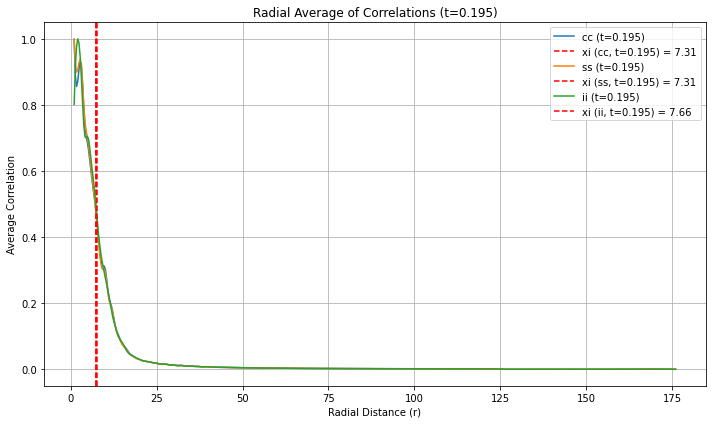

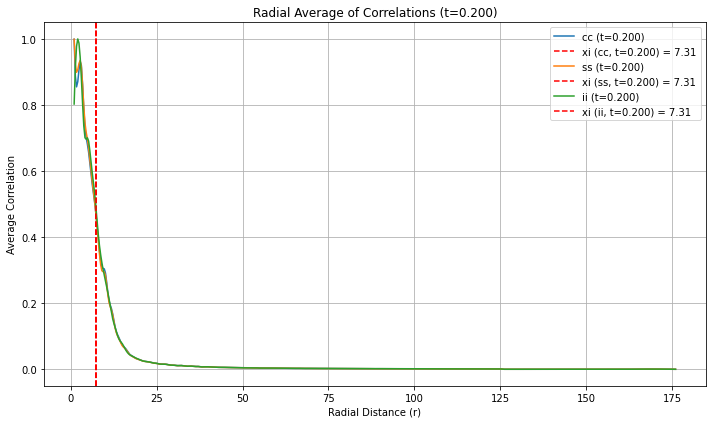

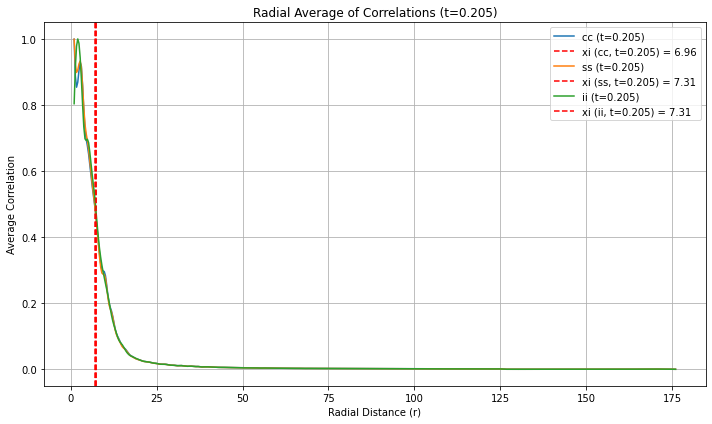

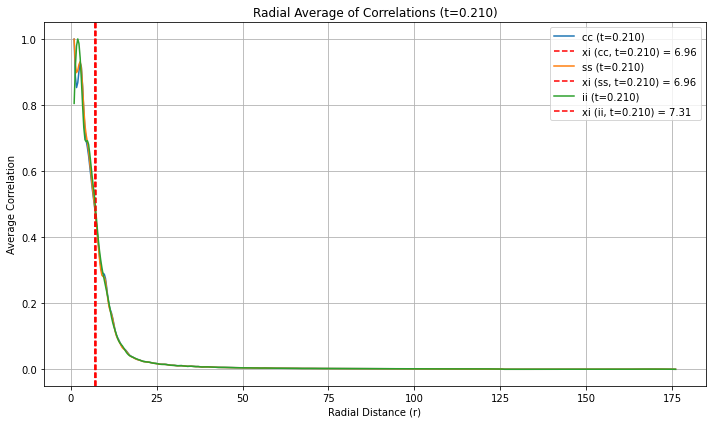

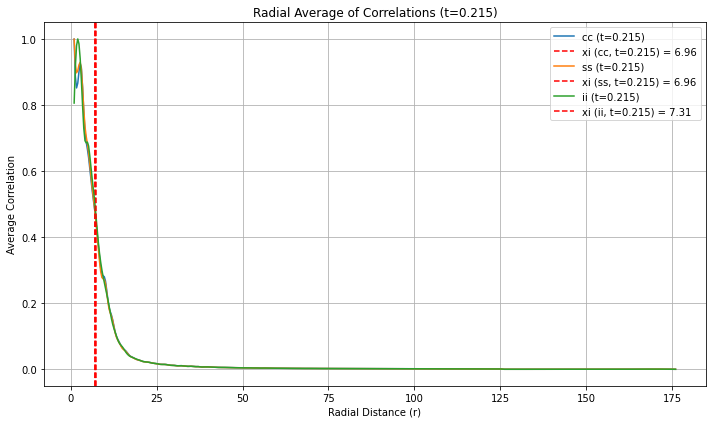

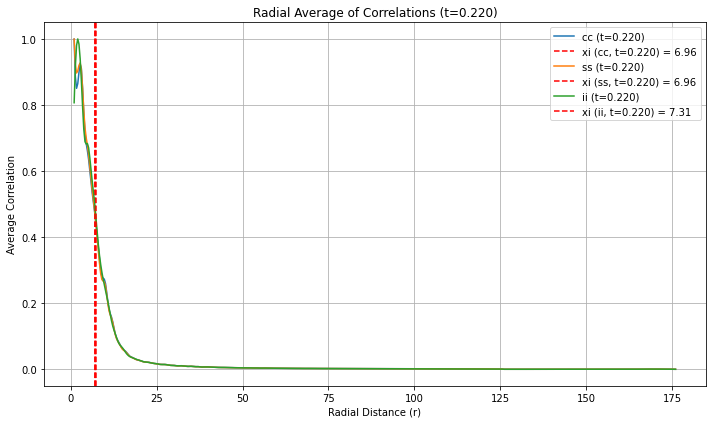

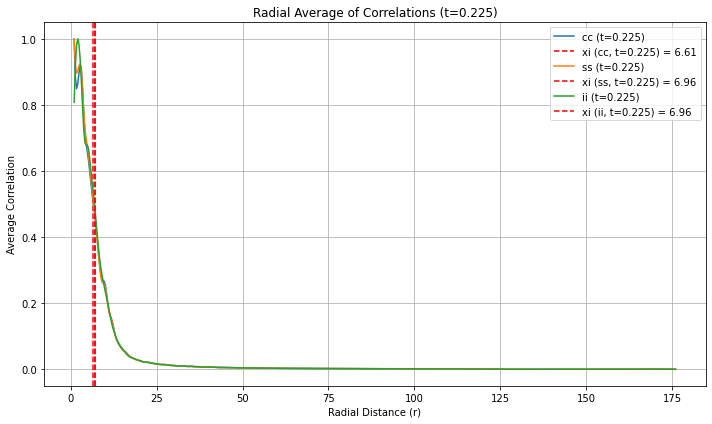

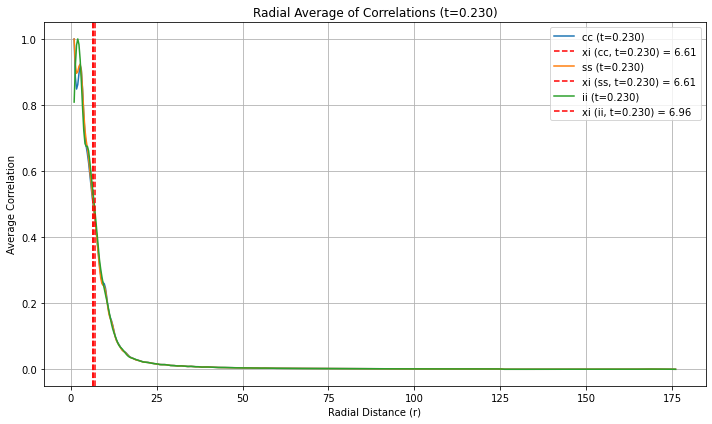

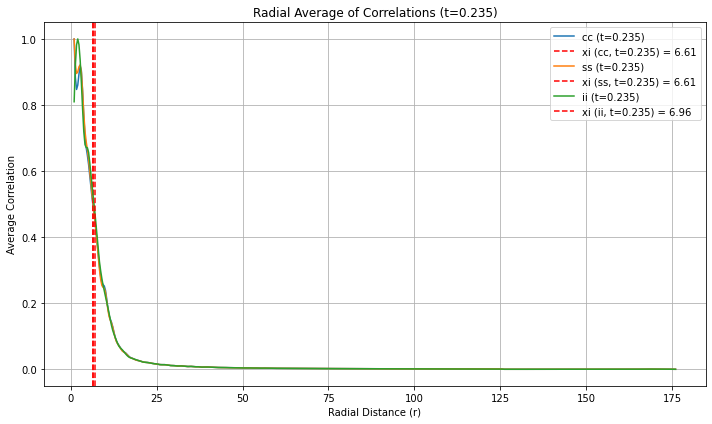

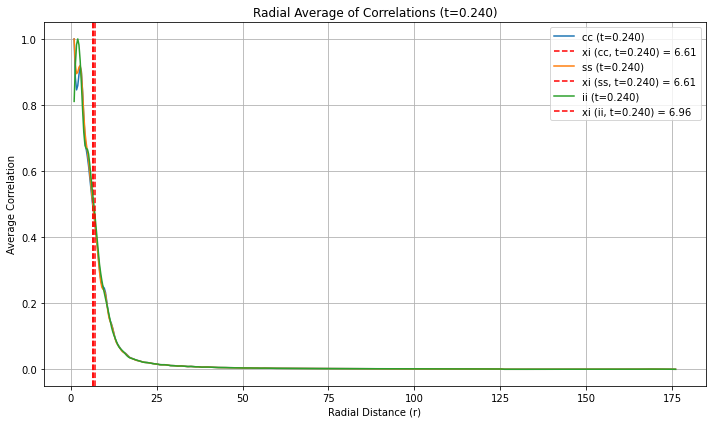

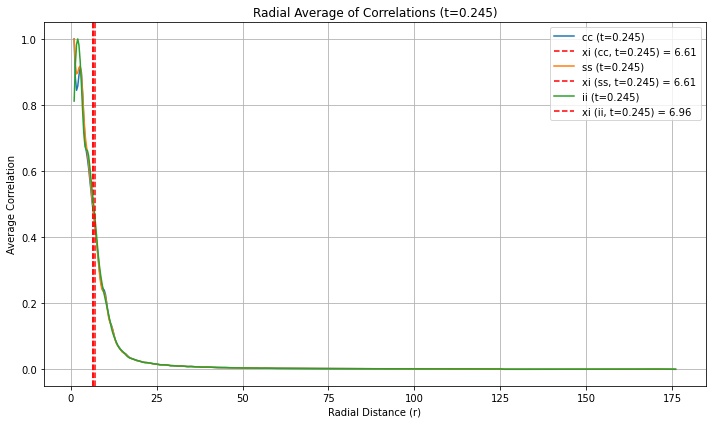

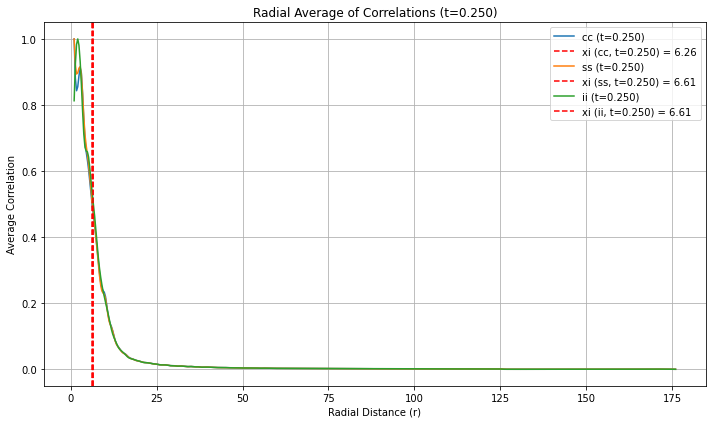

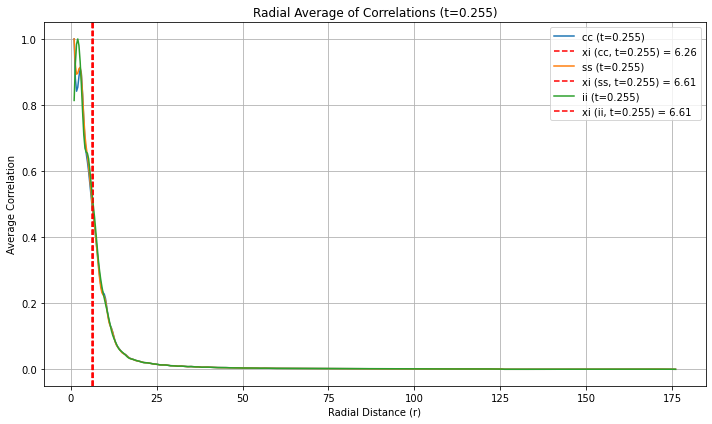

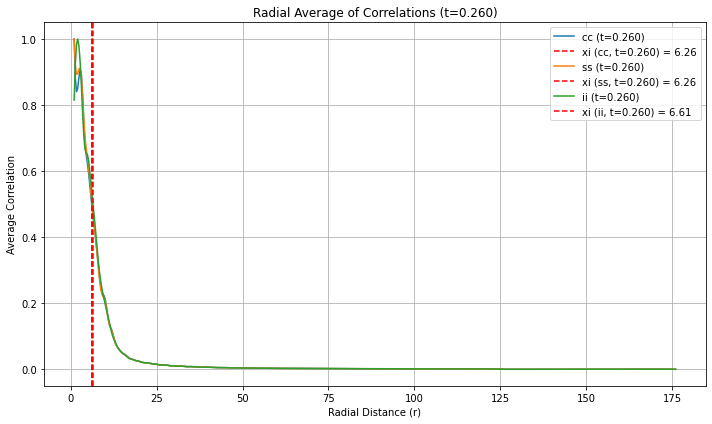

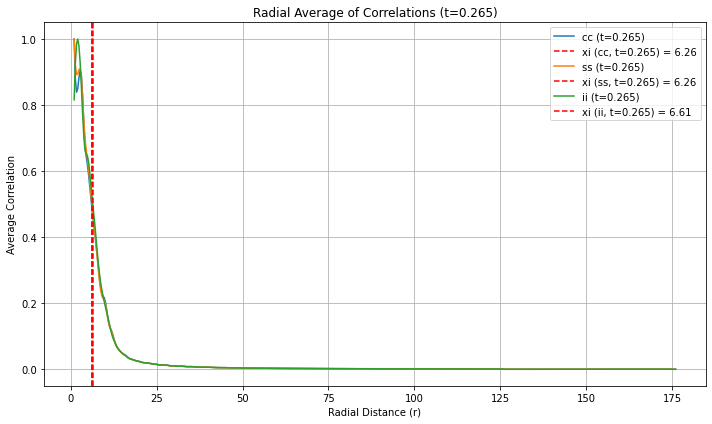

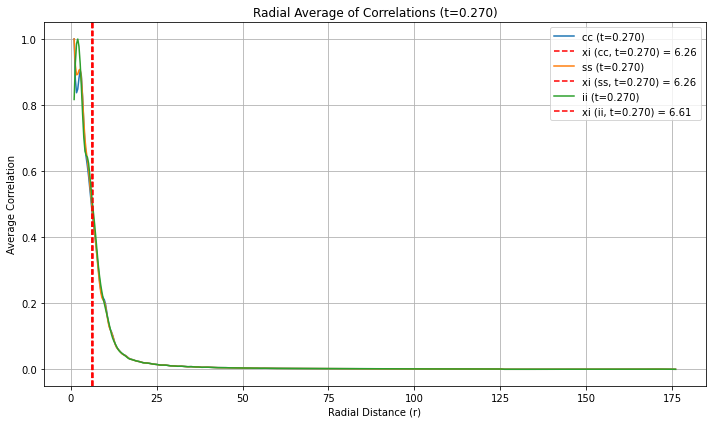

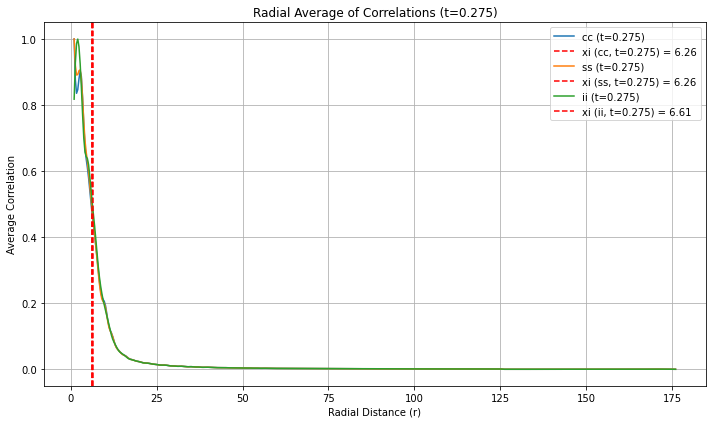

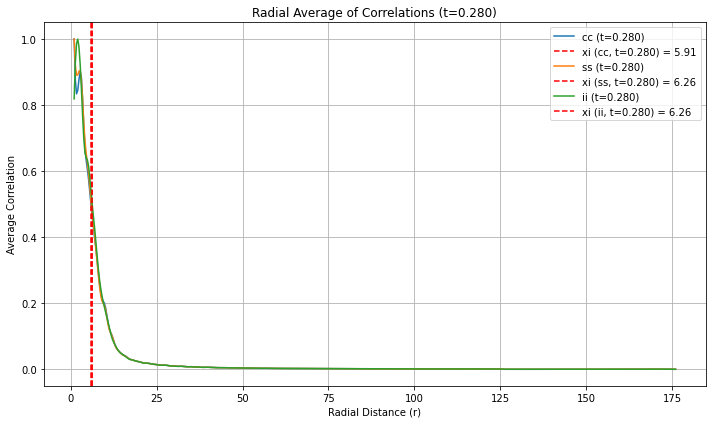

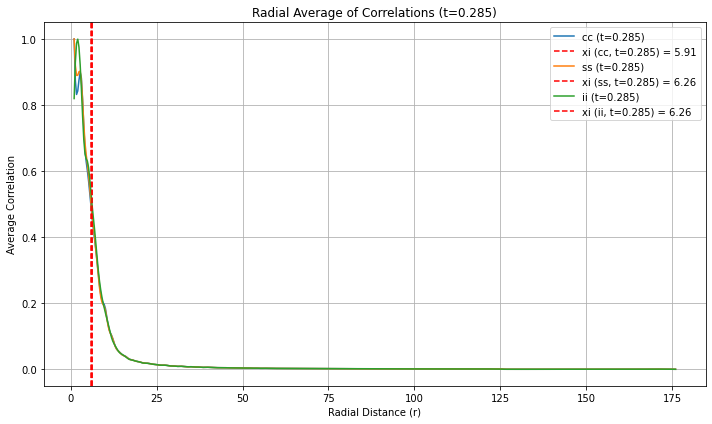

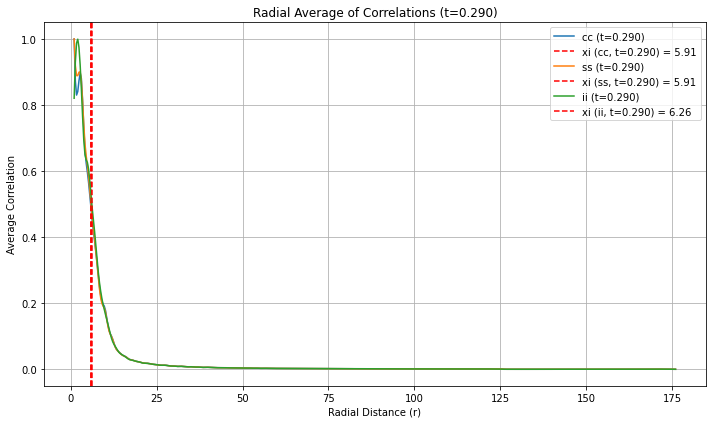

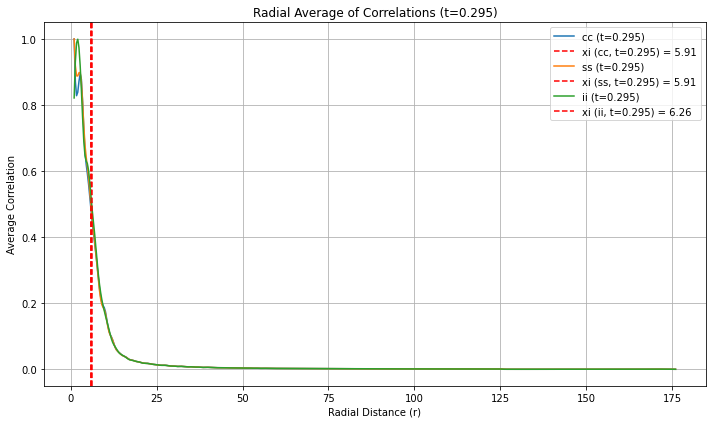

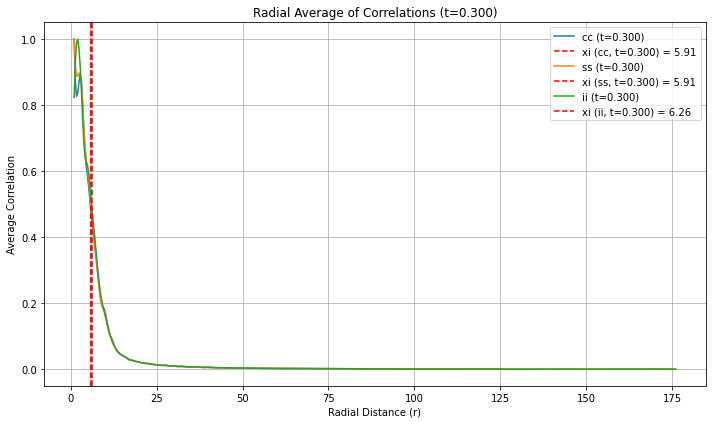

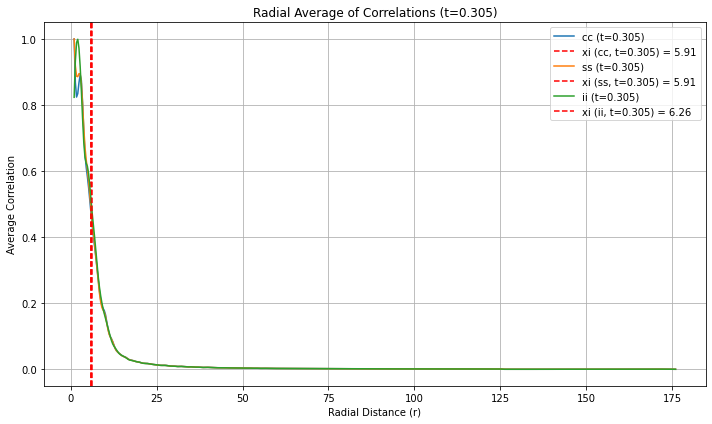

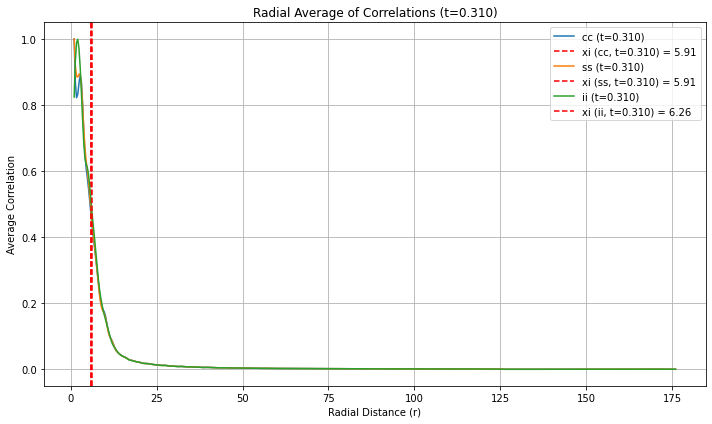

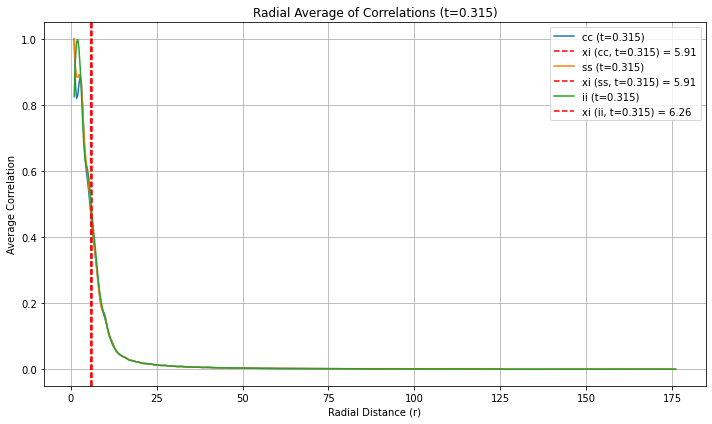

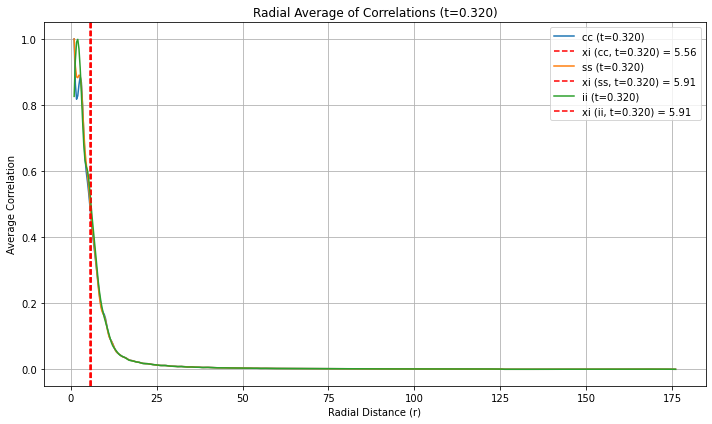

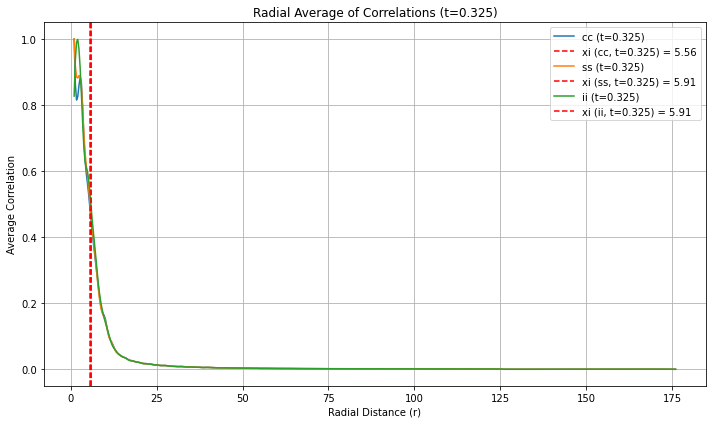

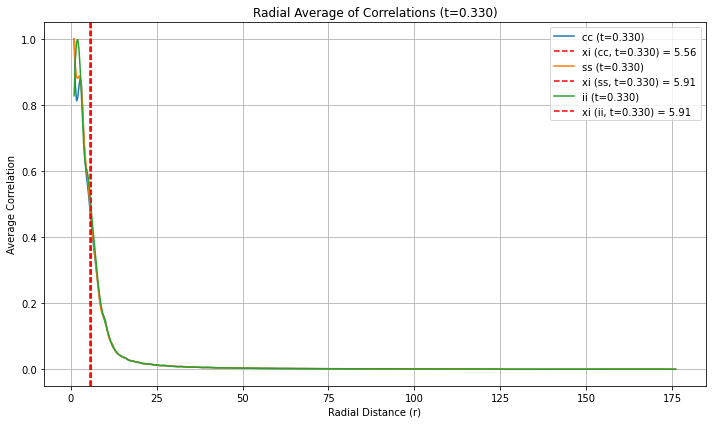

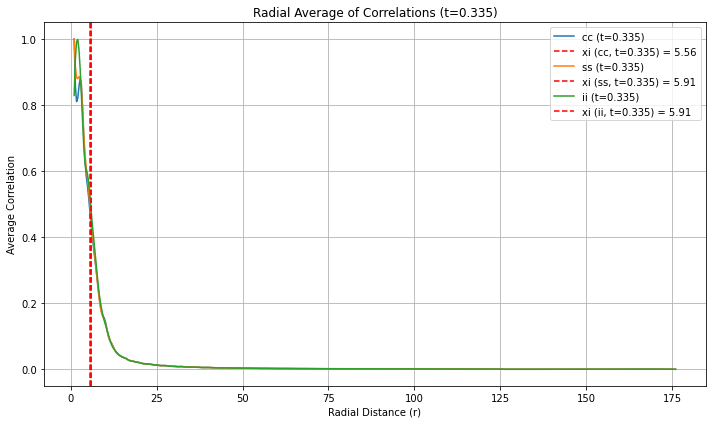

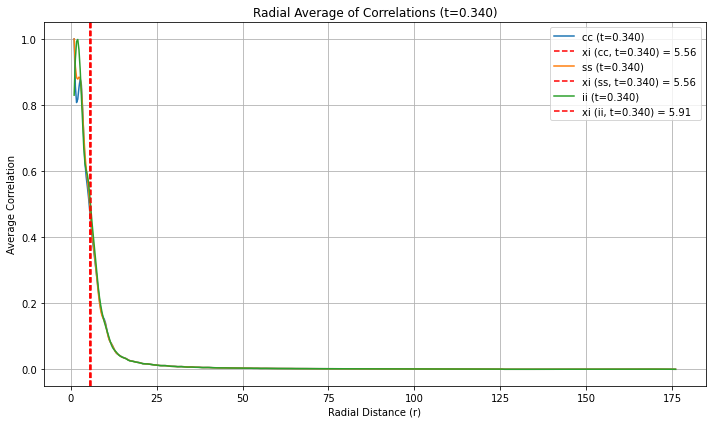

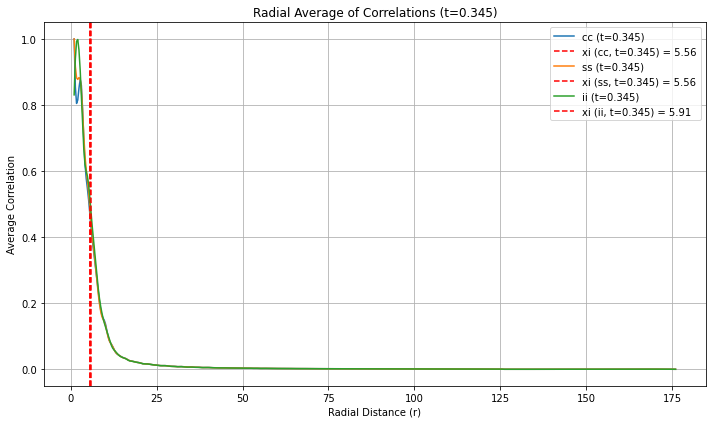

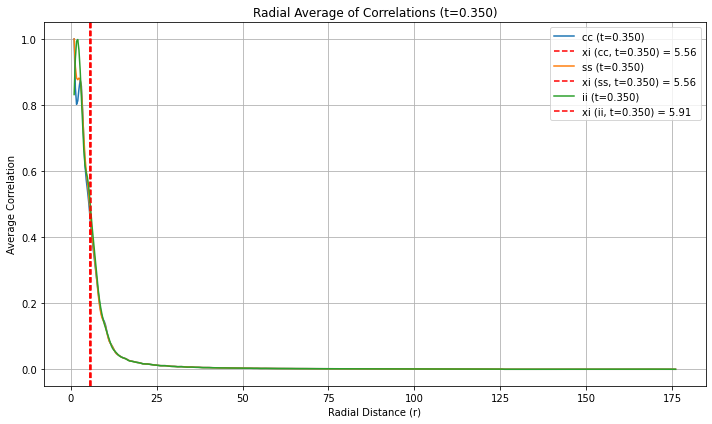

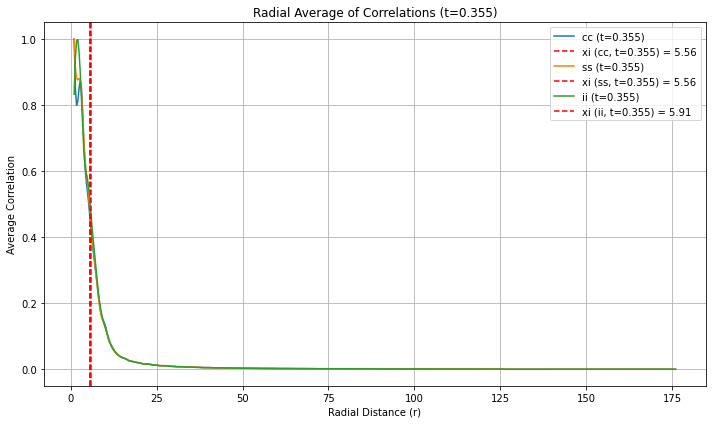

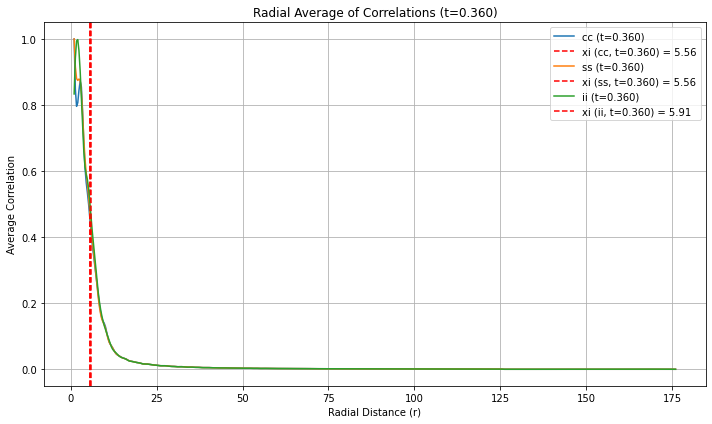

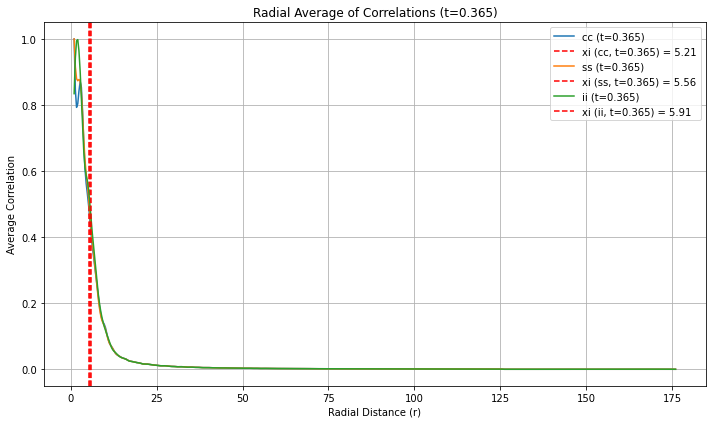

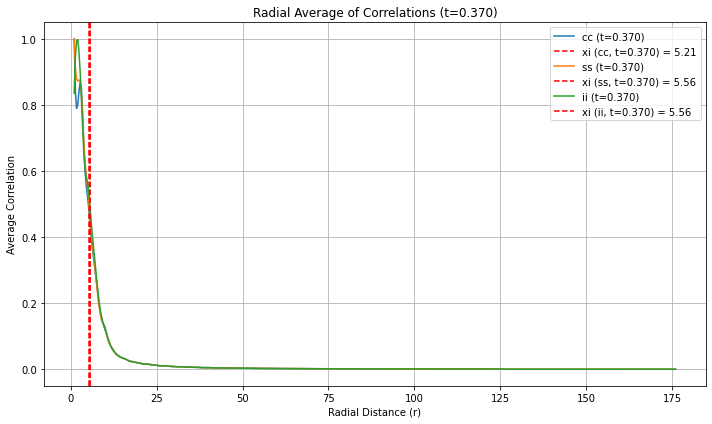

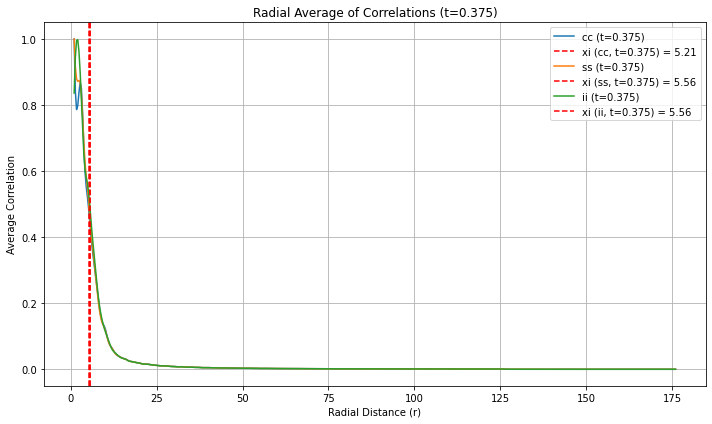

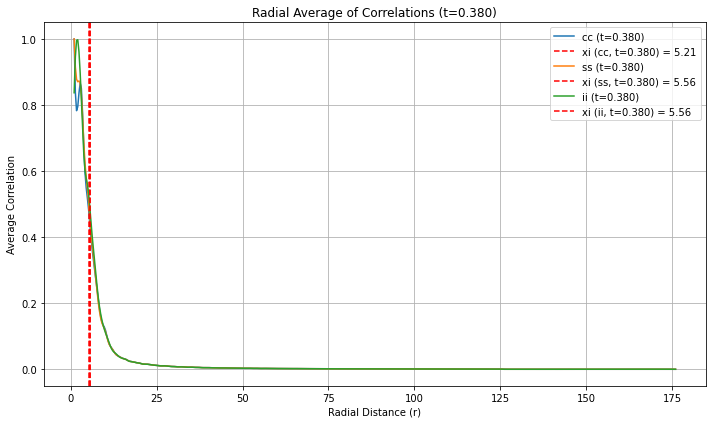

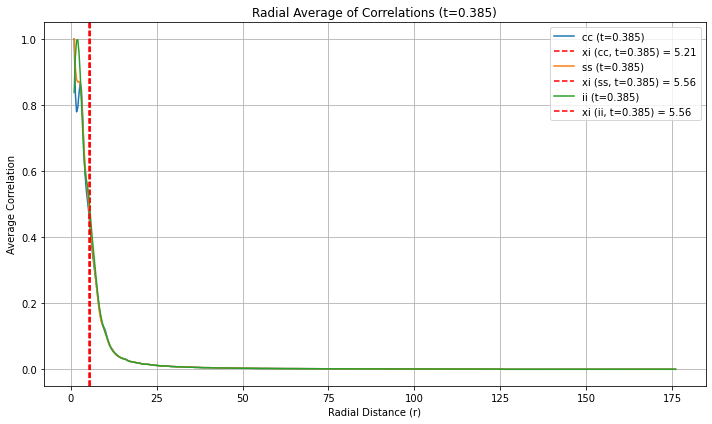

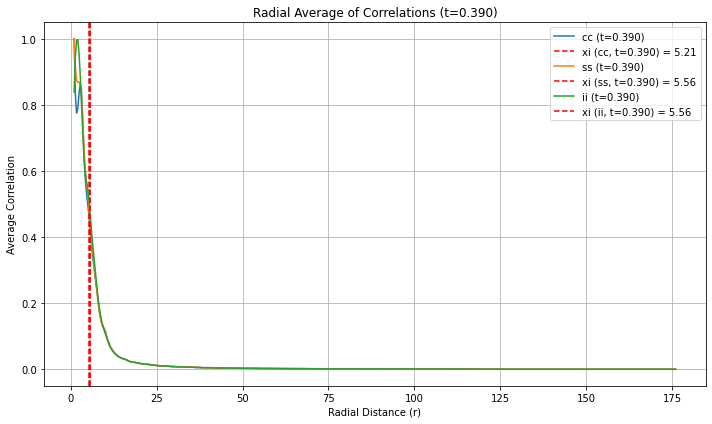

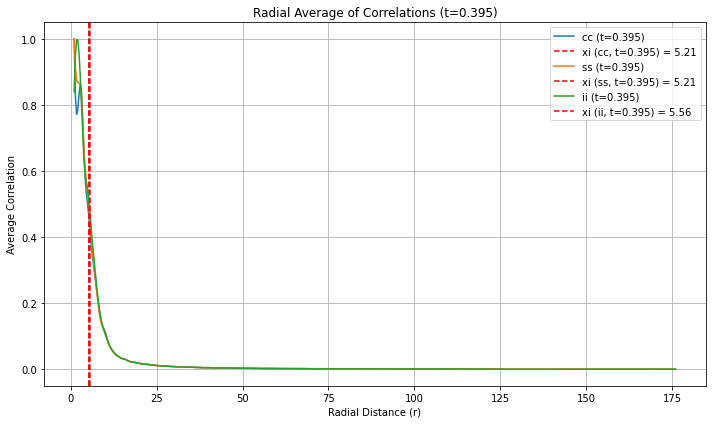

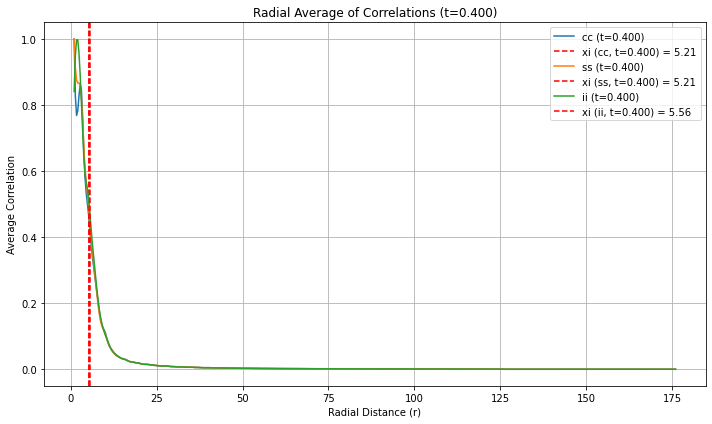

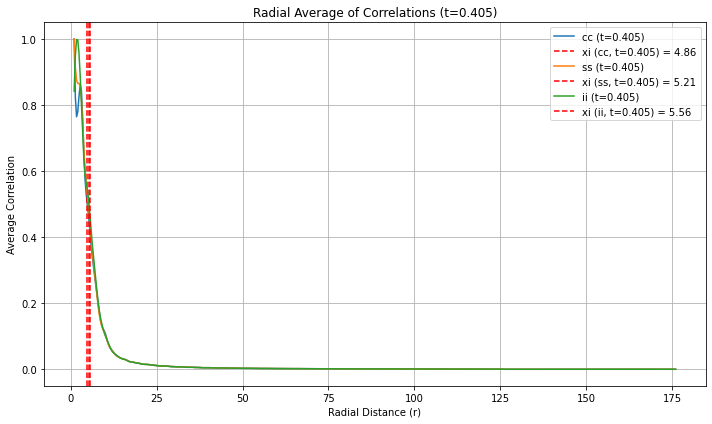

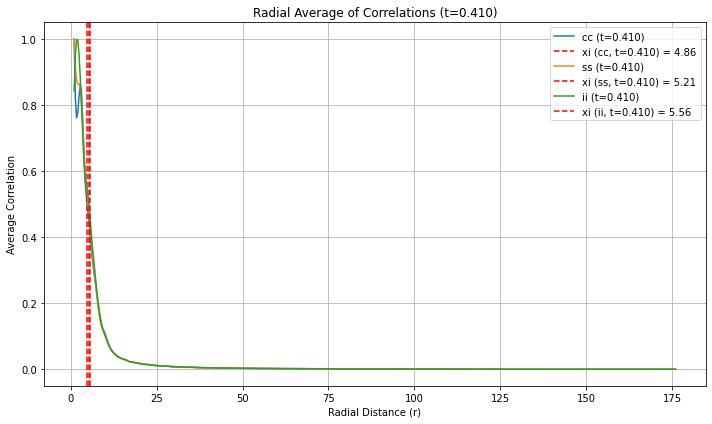

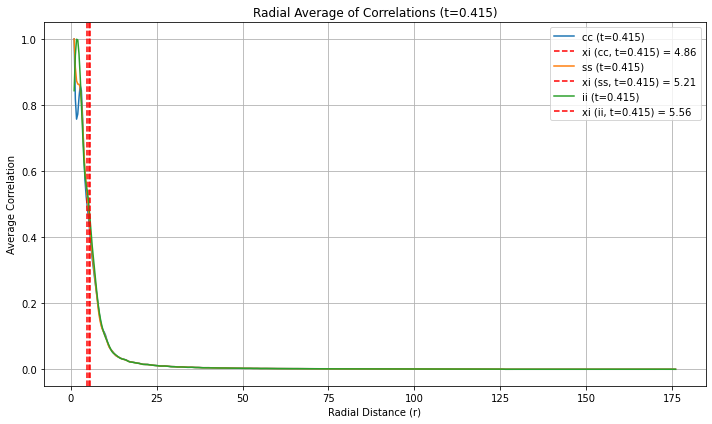

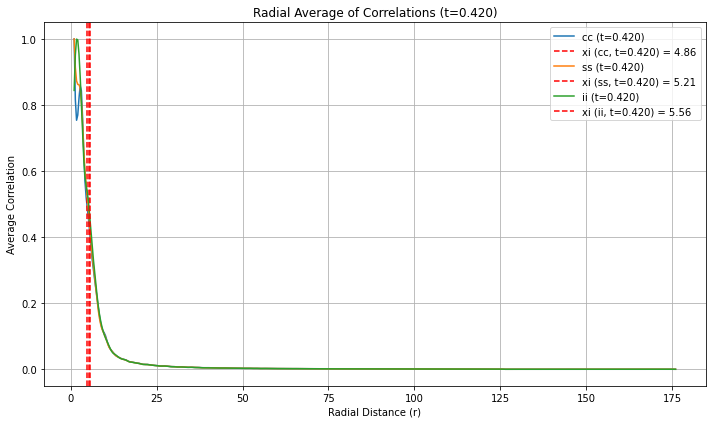

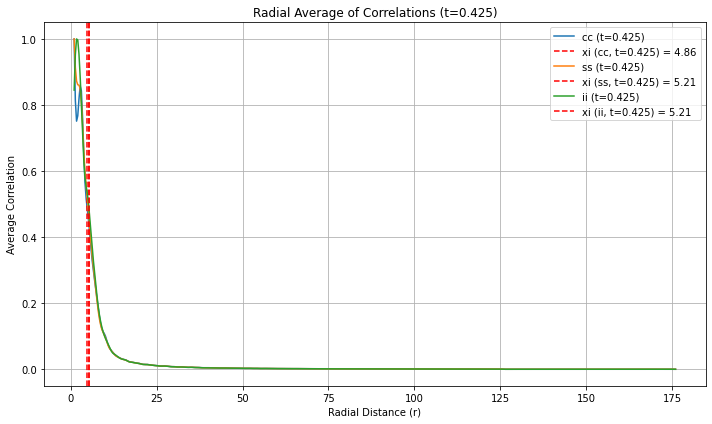

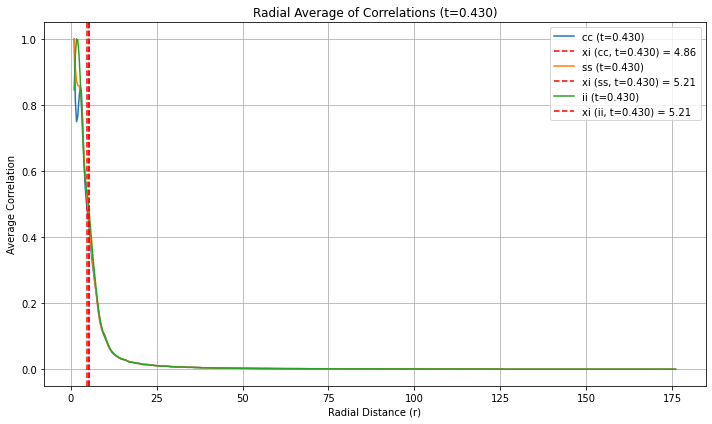

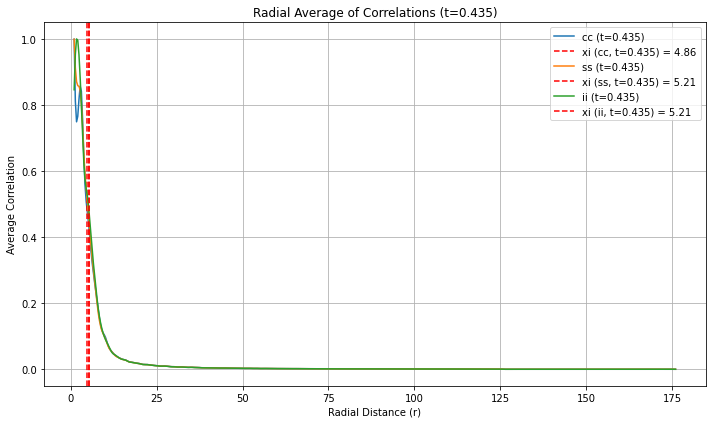

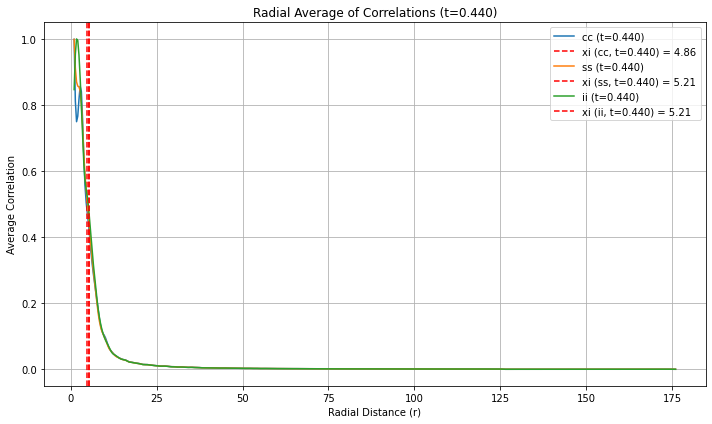

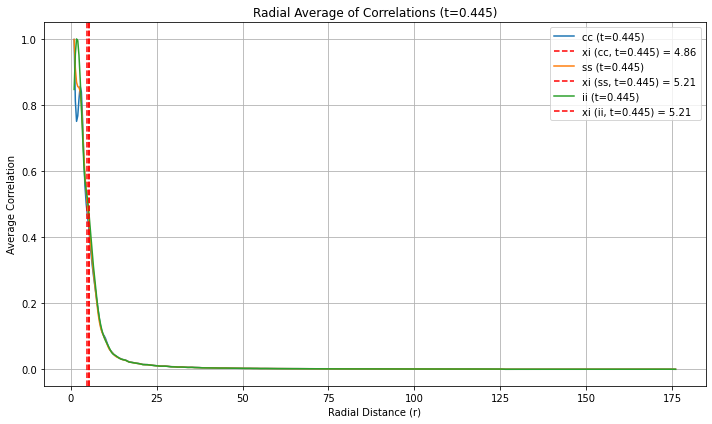

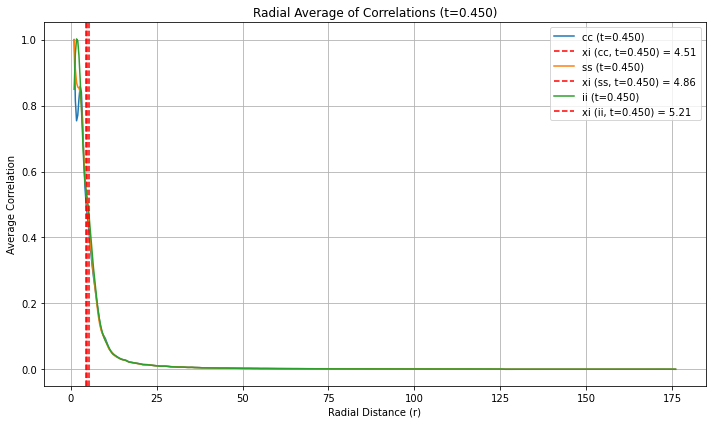

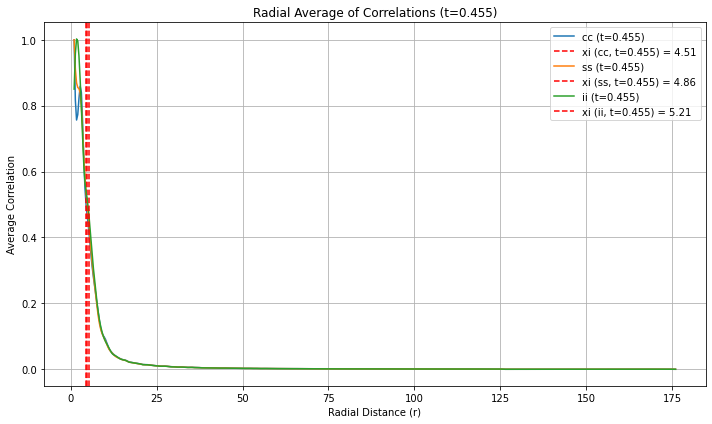

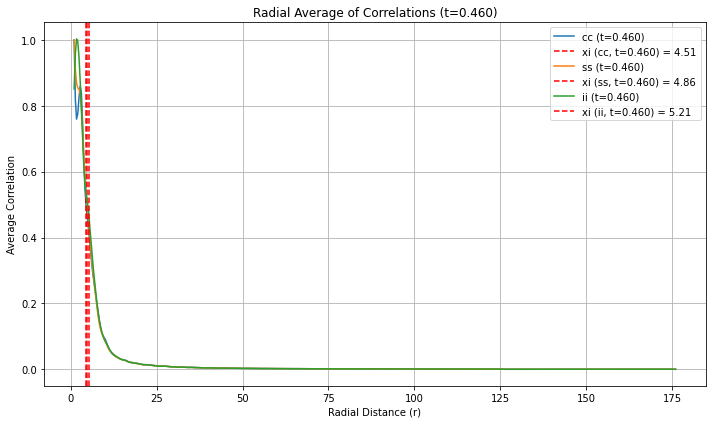

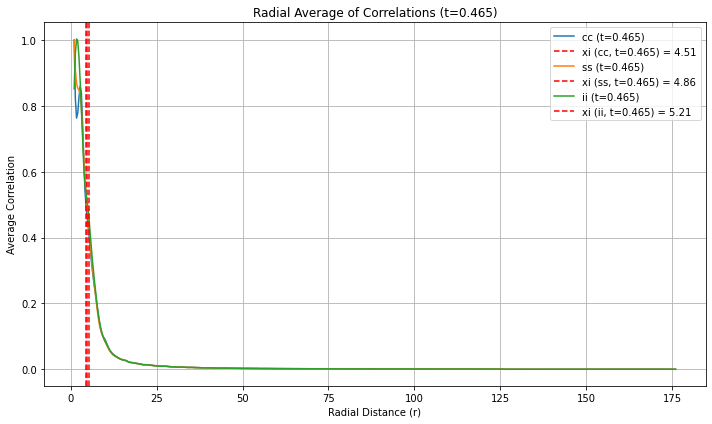

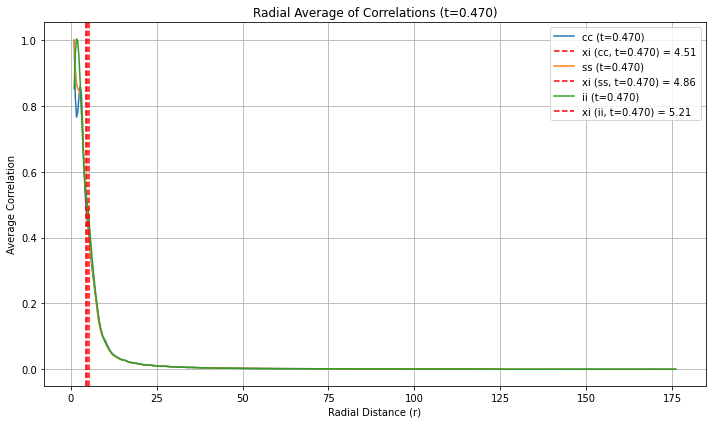

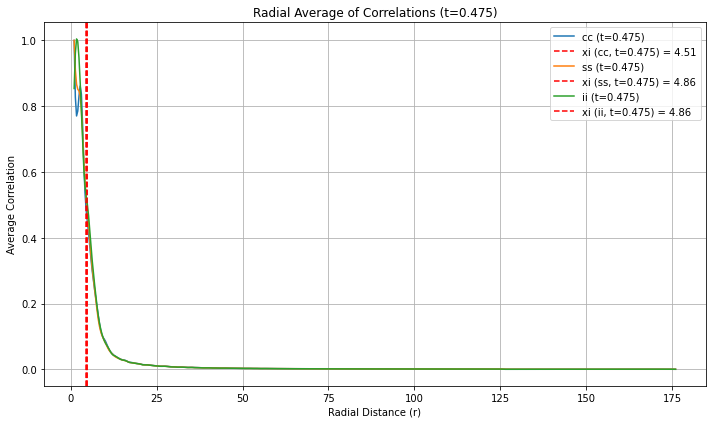

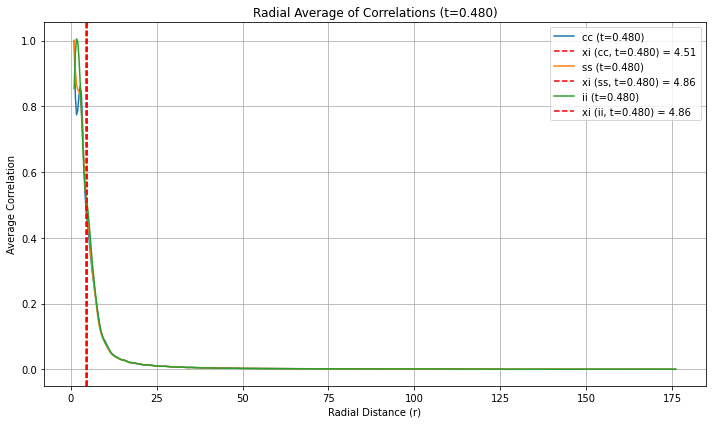

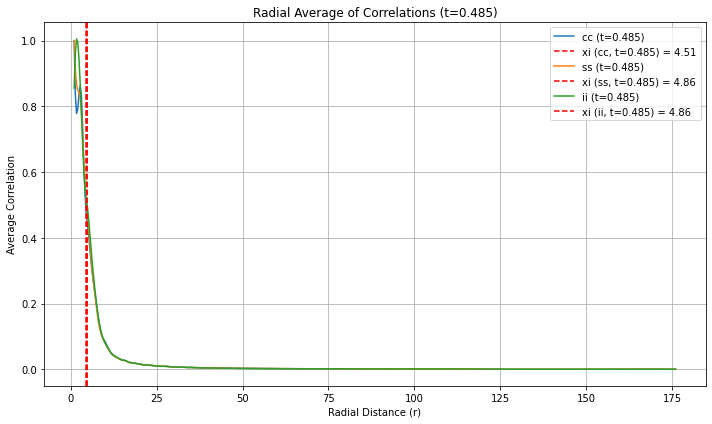

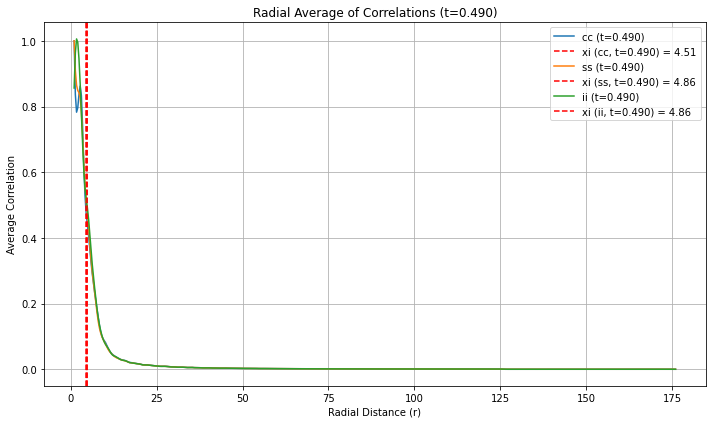

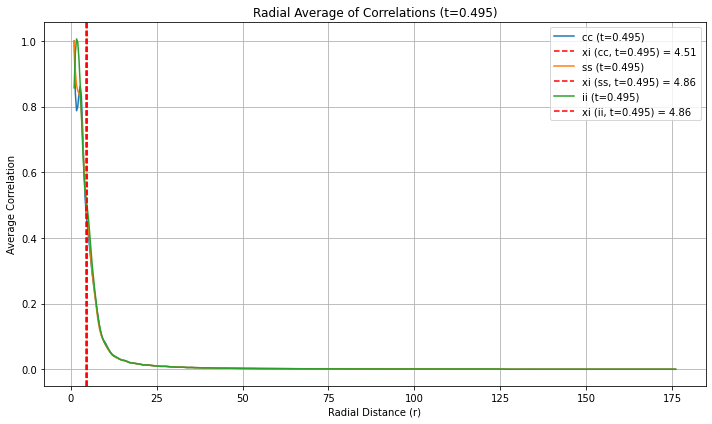

In [41]:
load_and_plot_radial_data(
    start_step=0, 
    end_step=T-dt, 
    dt=dt, 
    corr_types=["cc", "ss", "ii"]
)

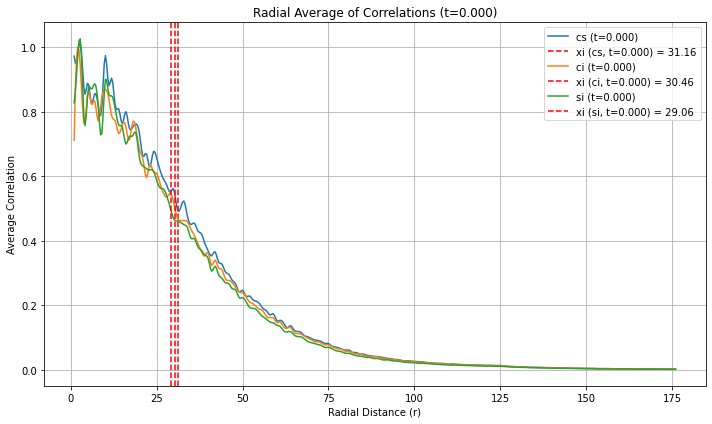

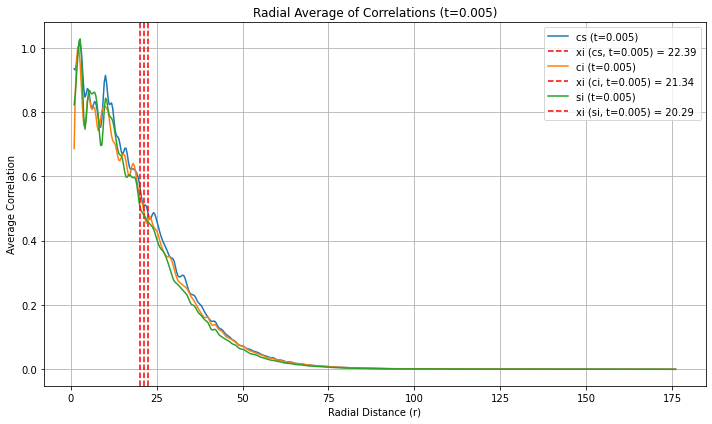

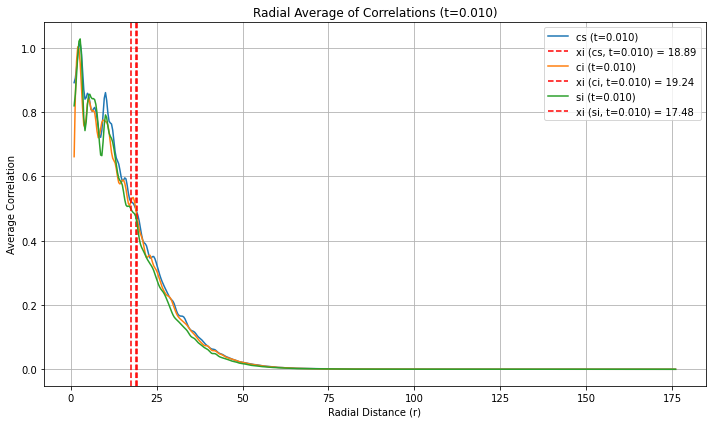

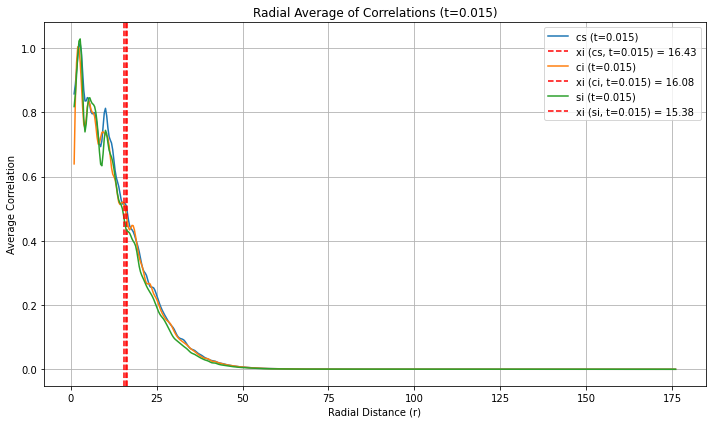

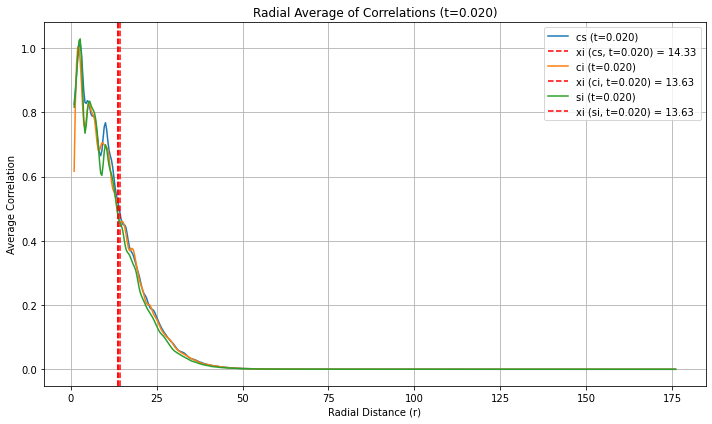

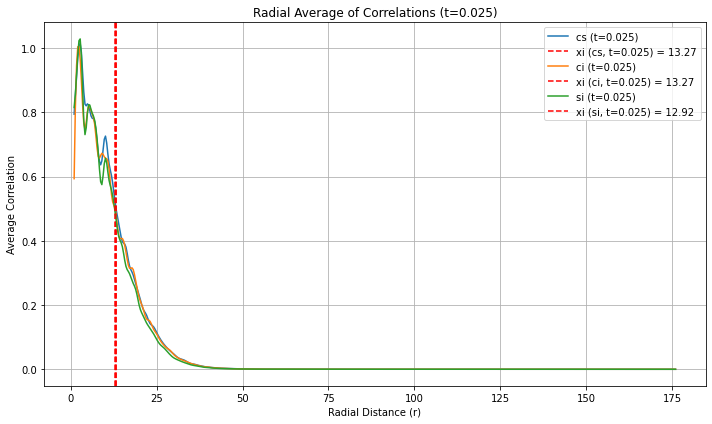

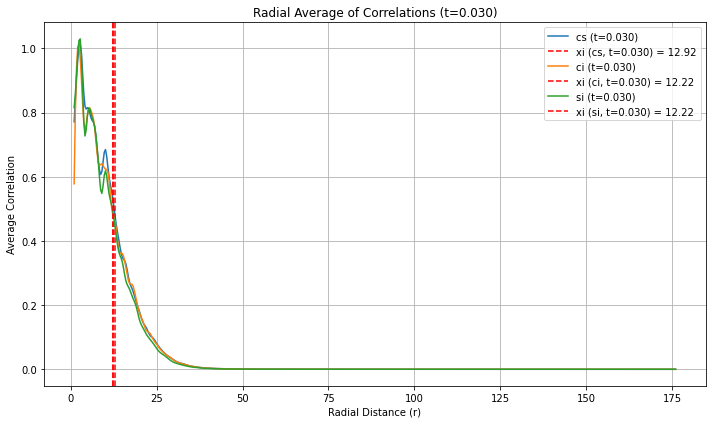

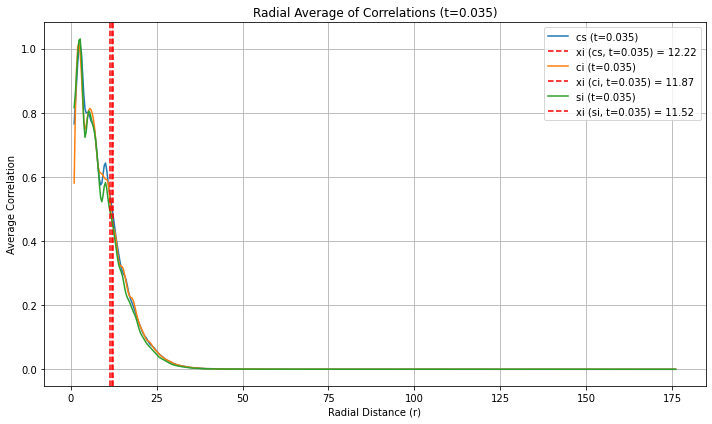

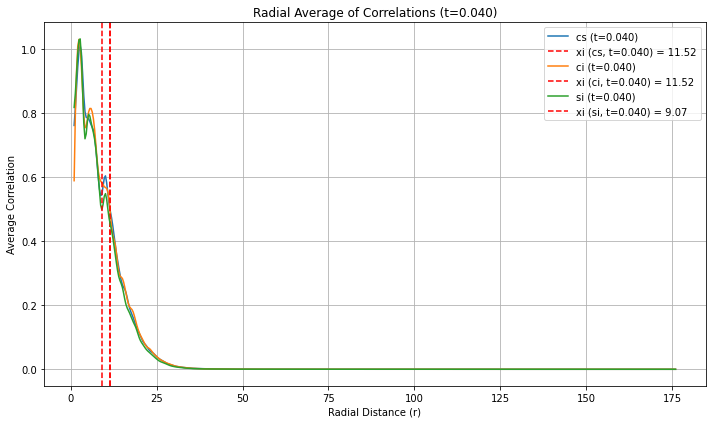

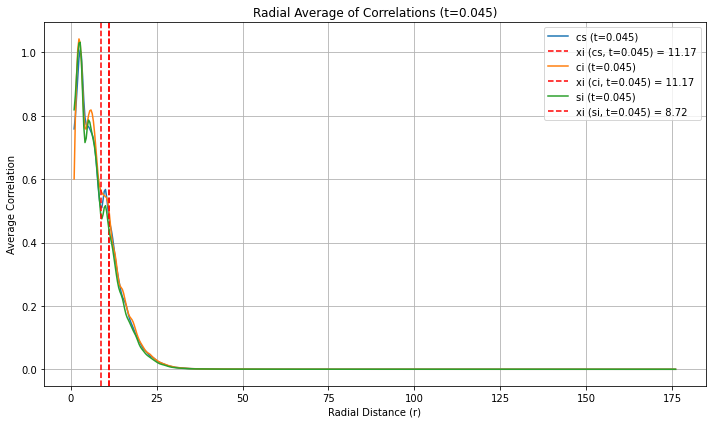

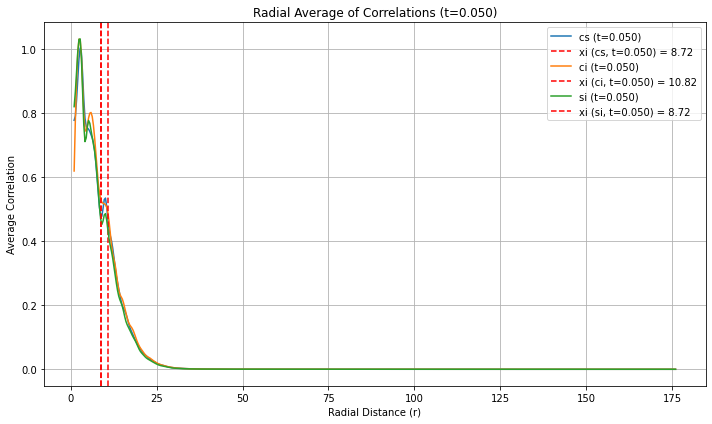

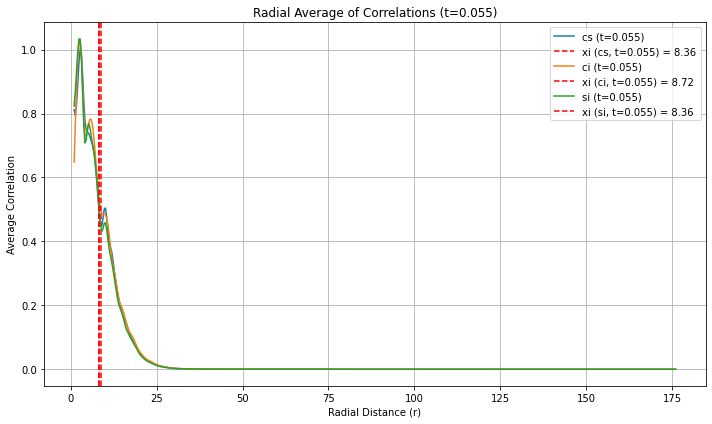

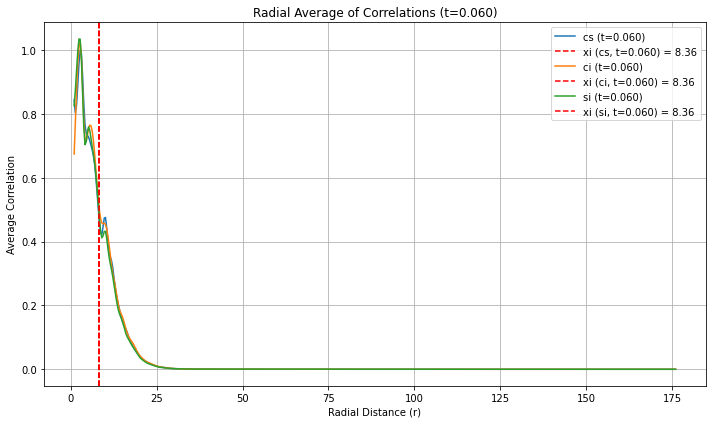

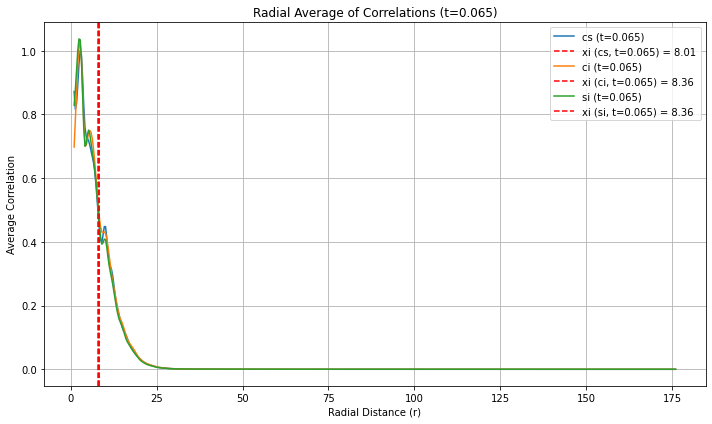

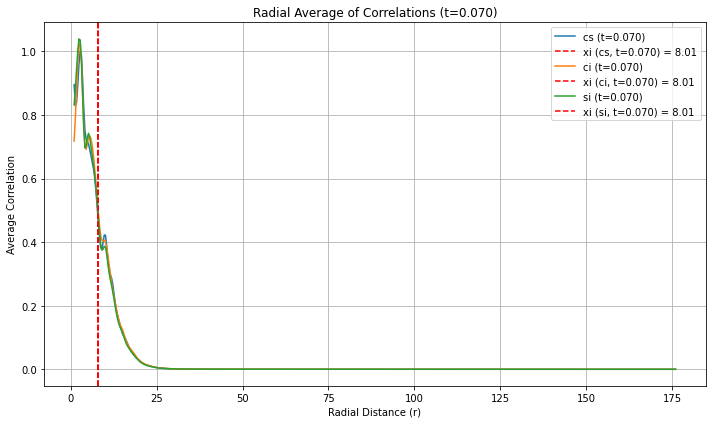

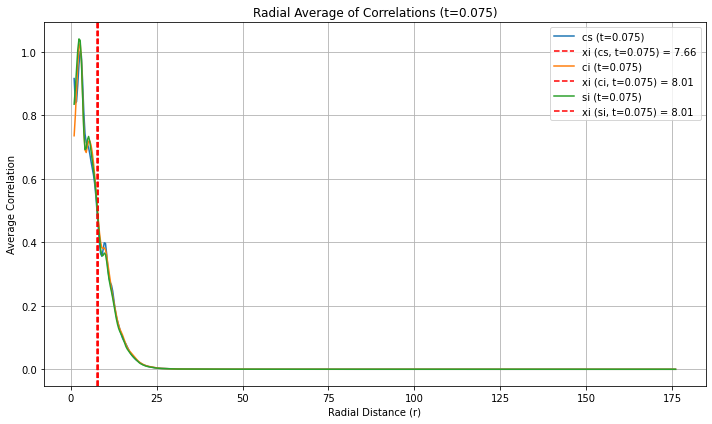

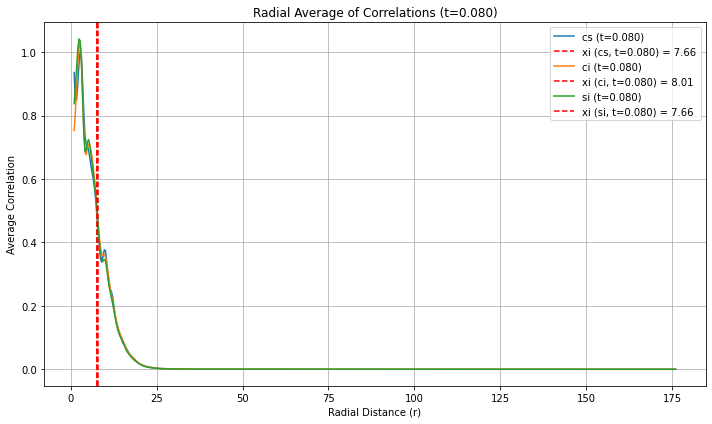

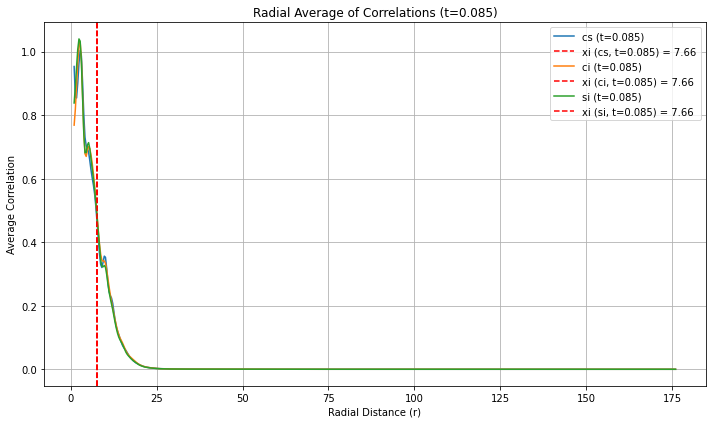

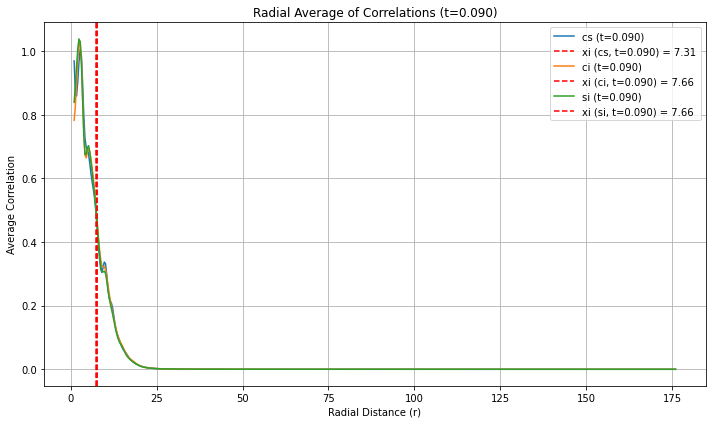

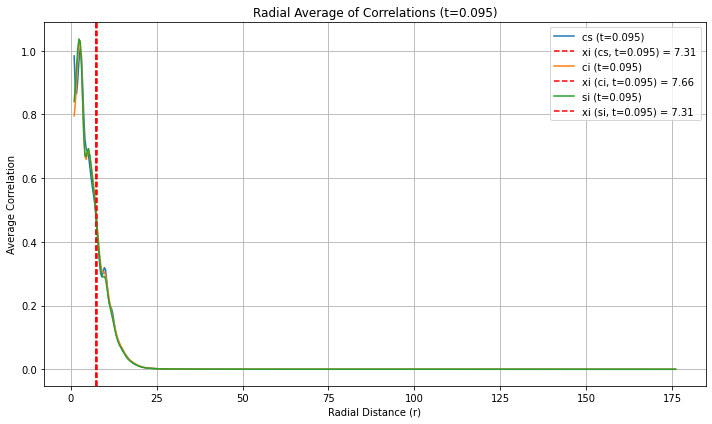

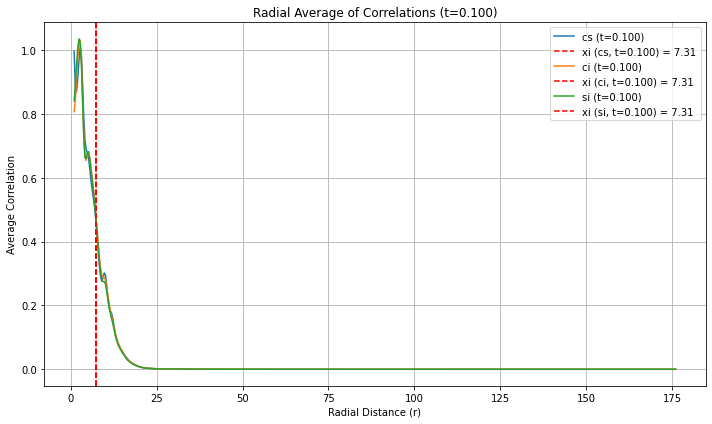

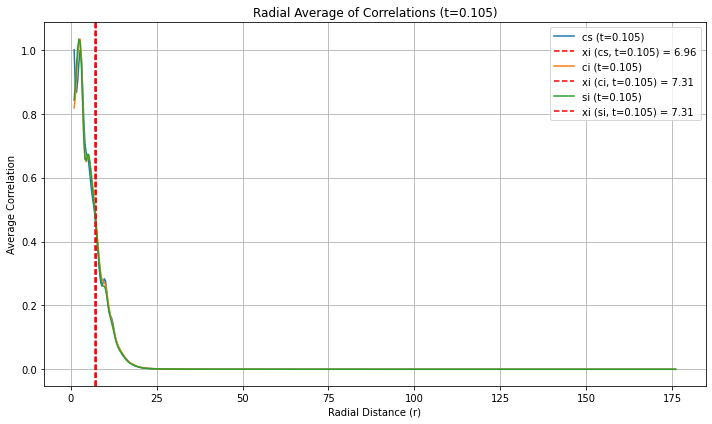

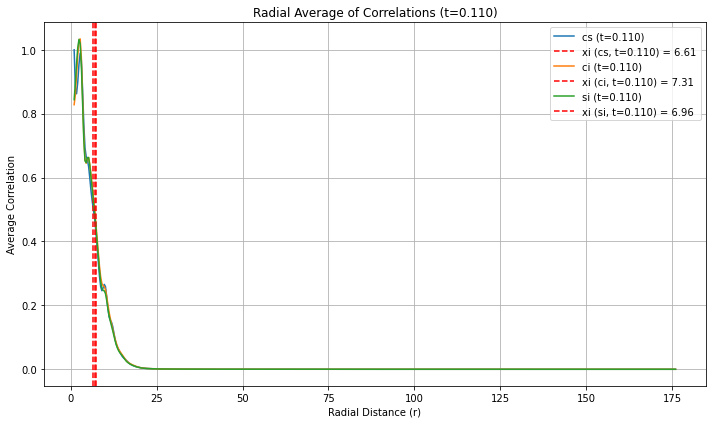

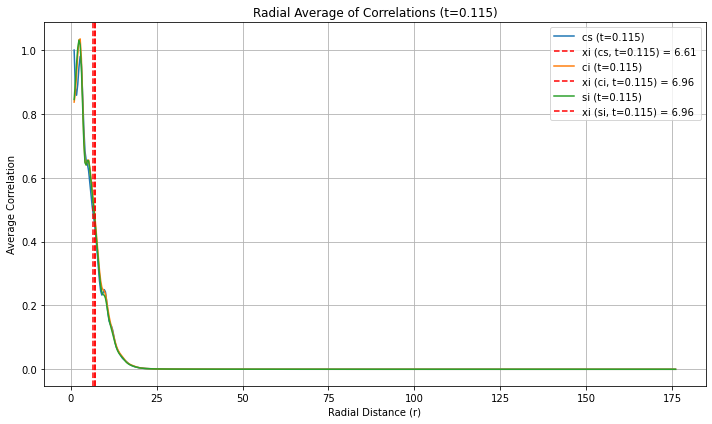

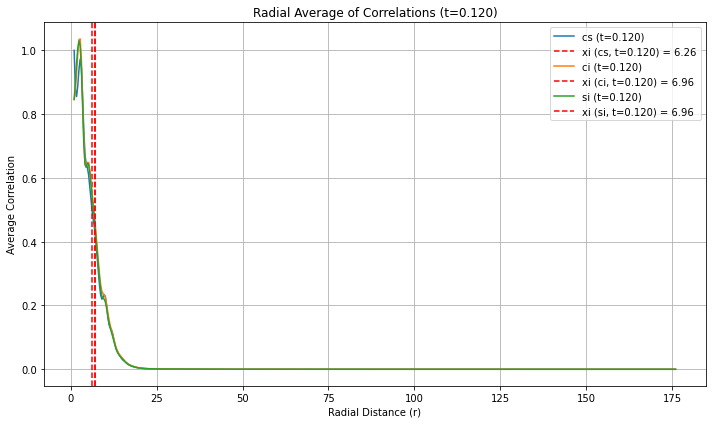

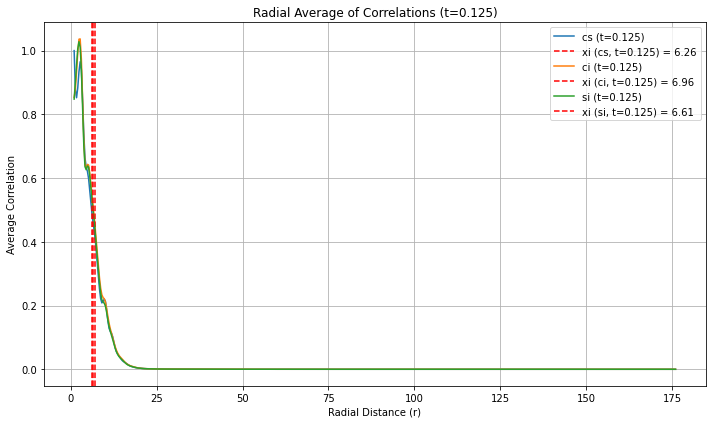

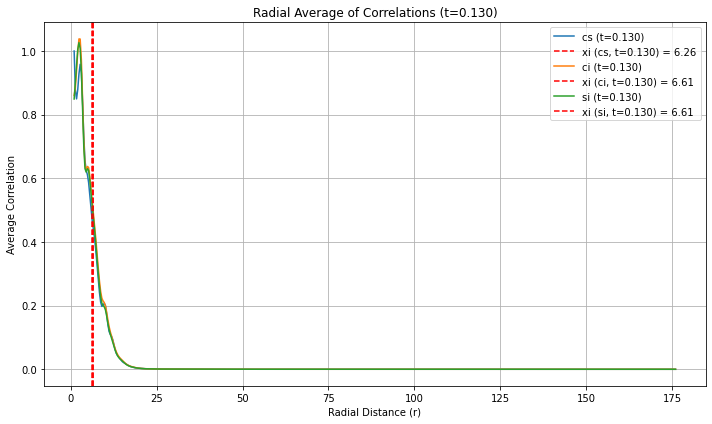

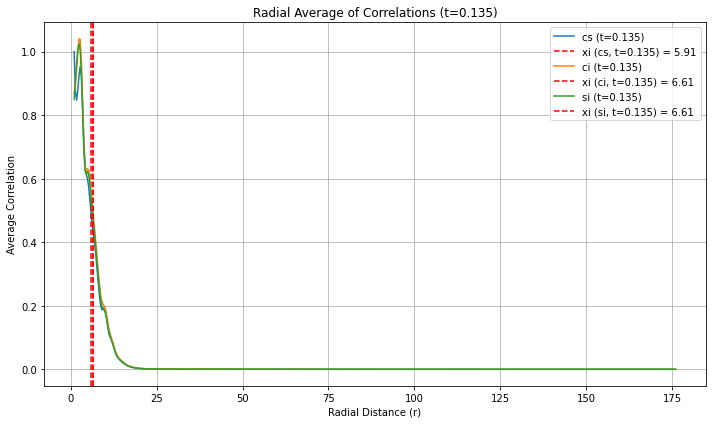

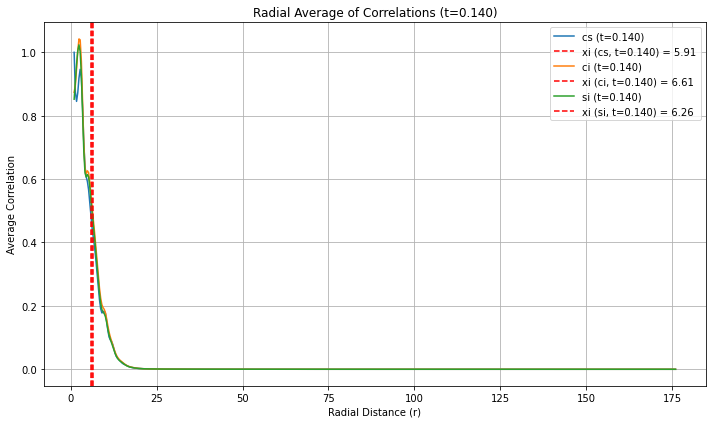

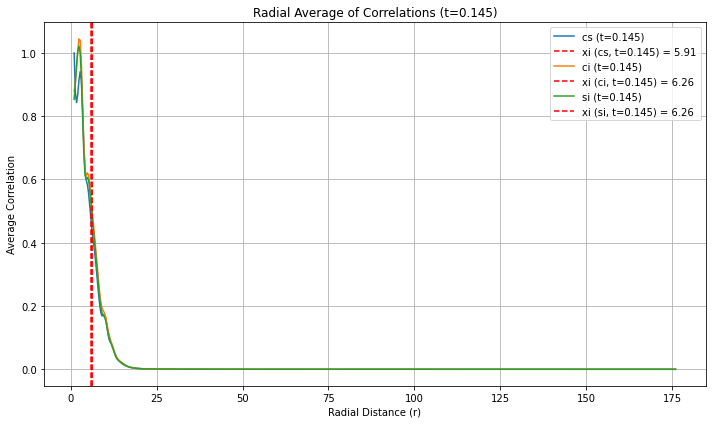

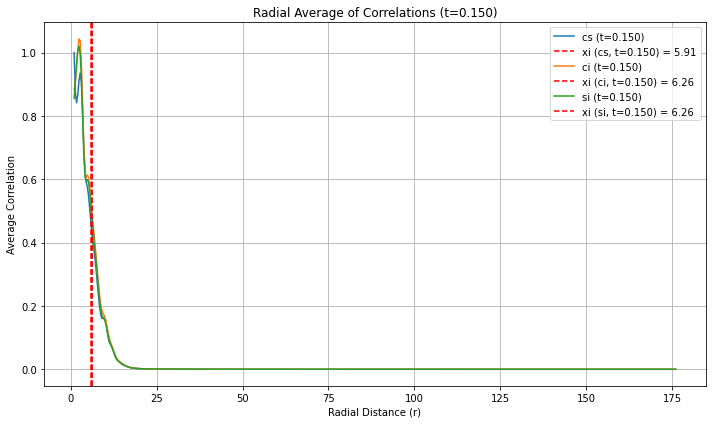

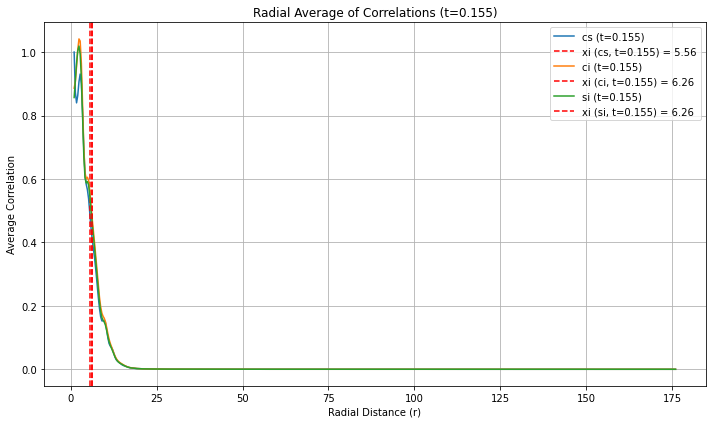

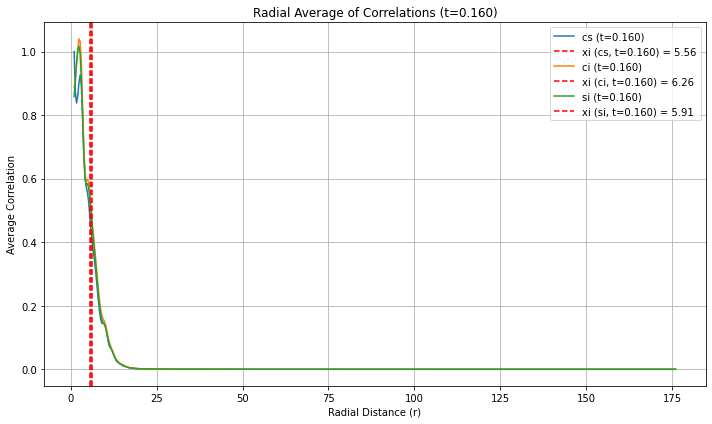

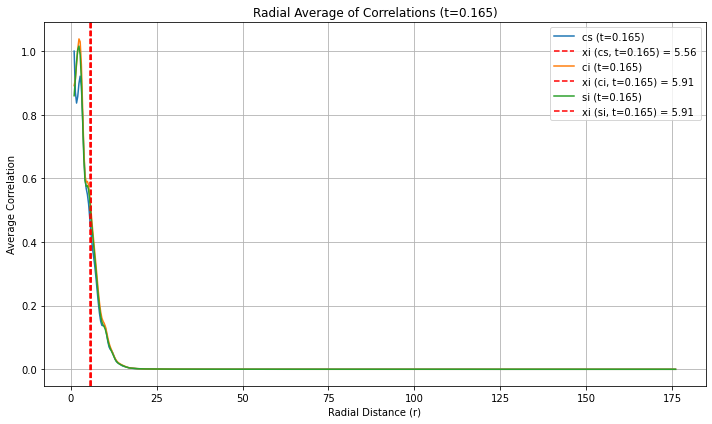

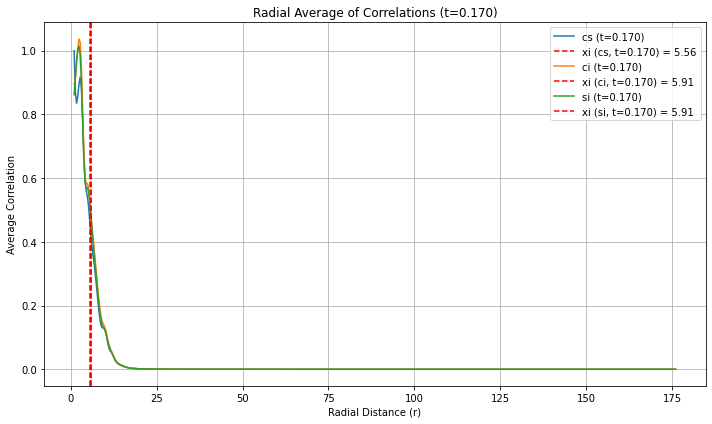

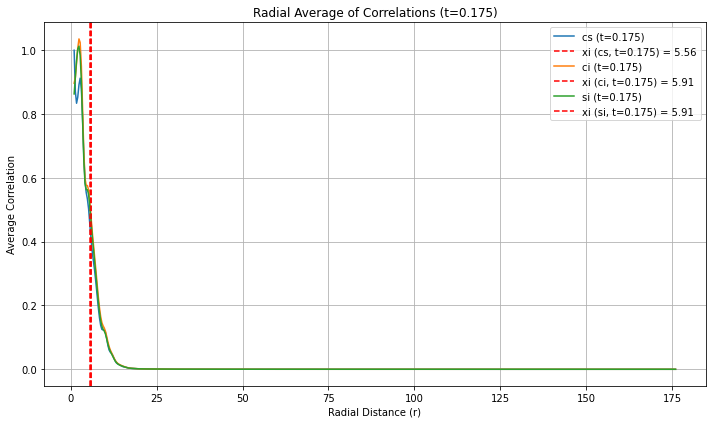

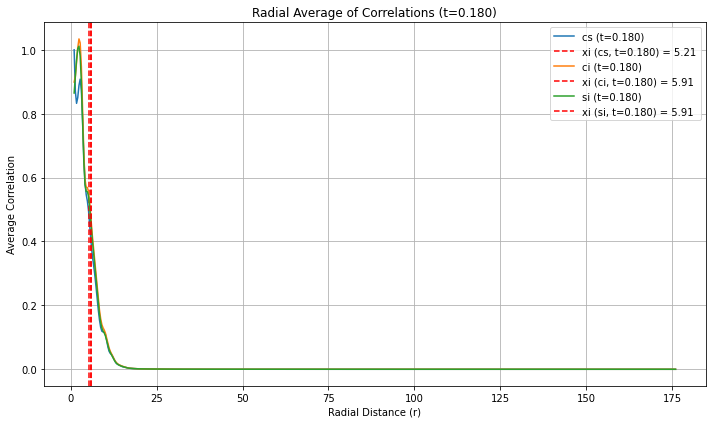

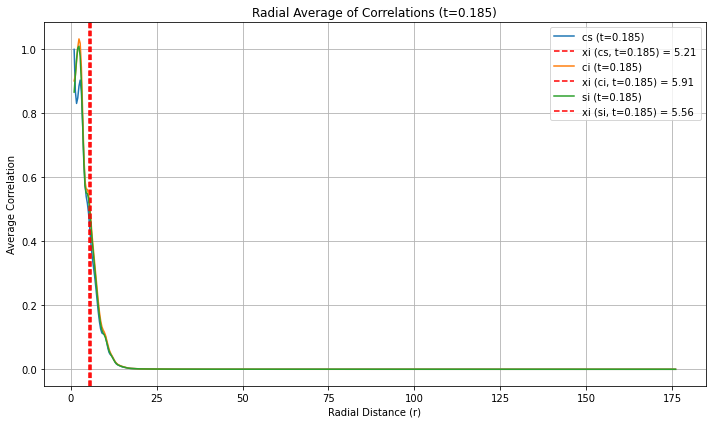

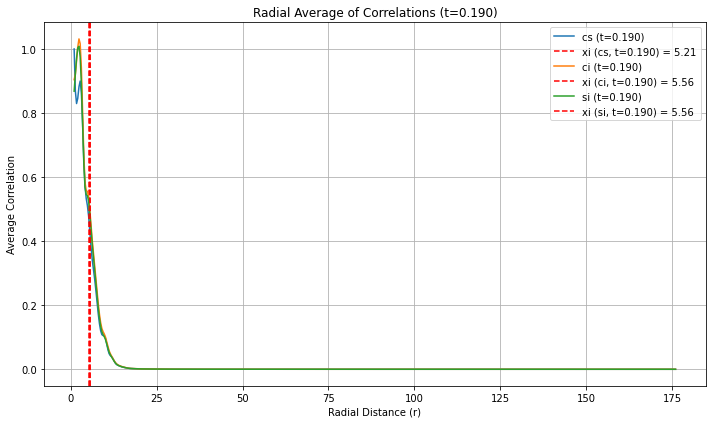

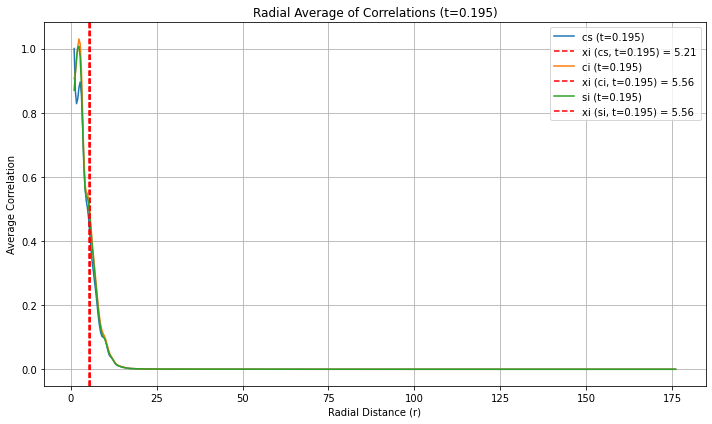

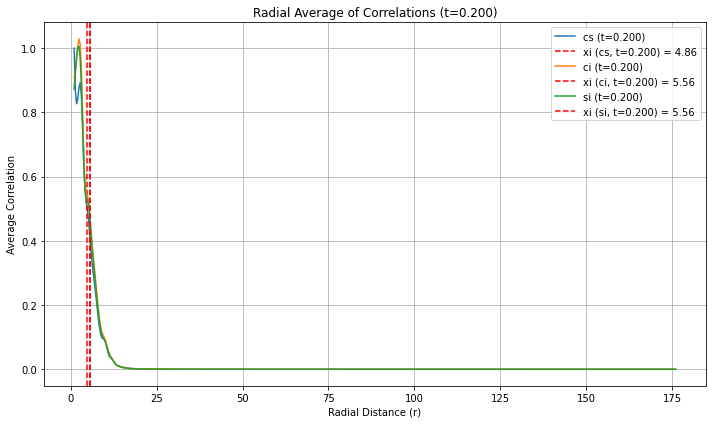

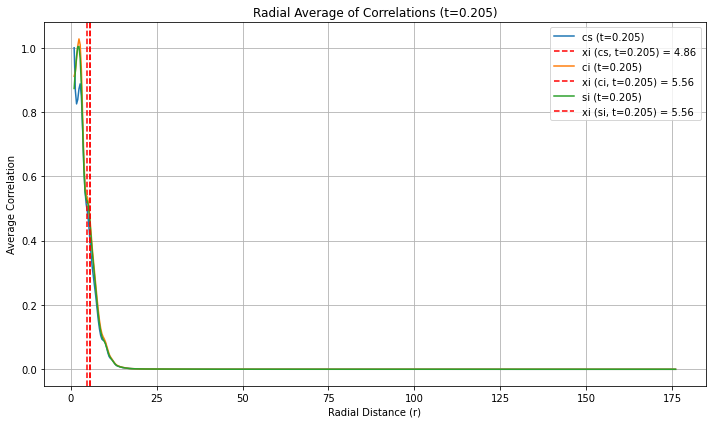

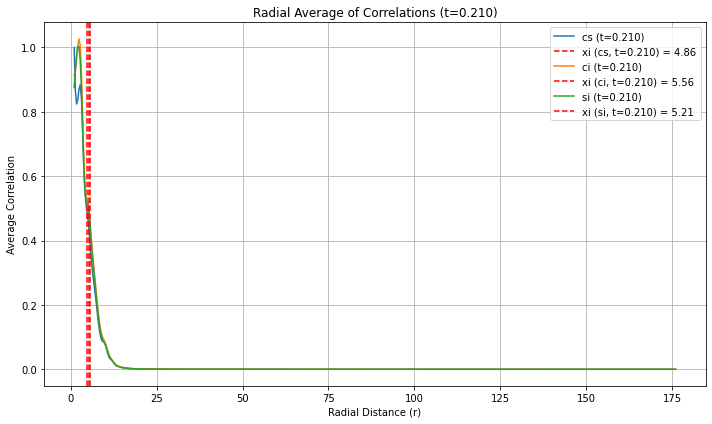

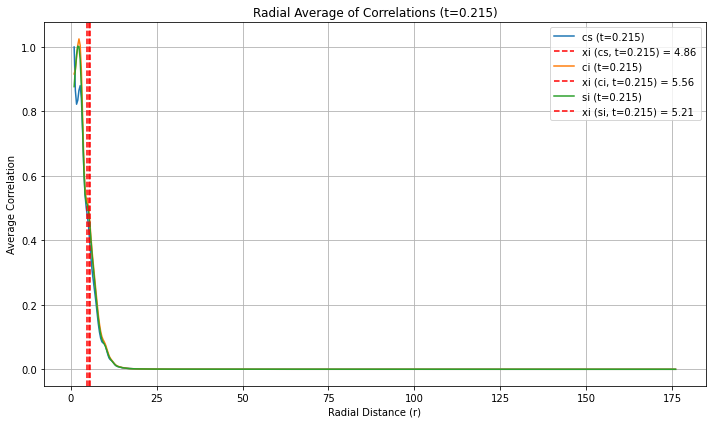

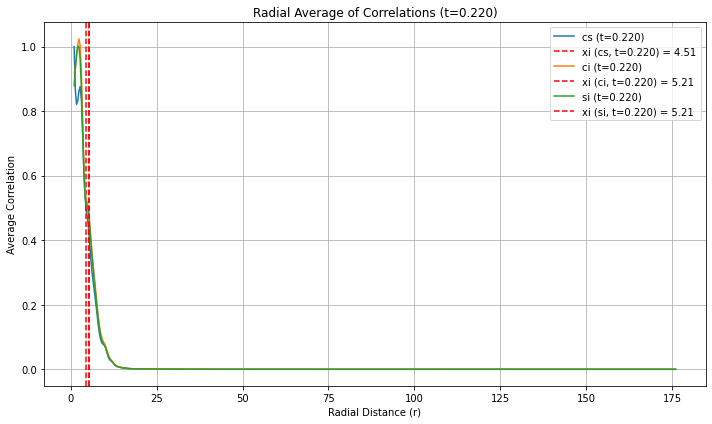

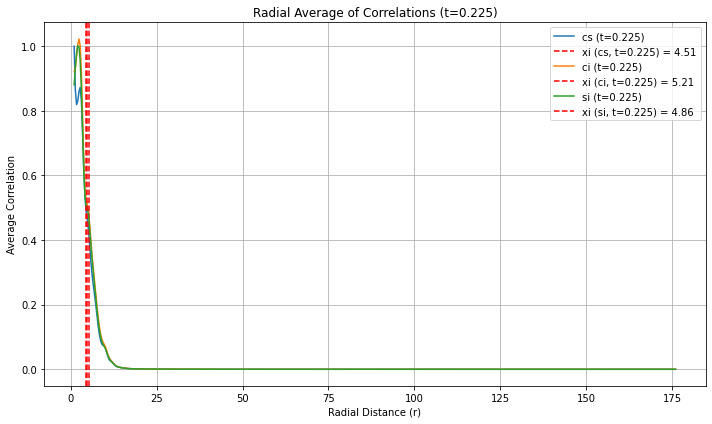

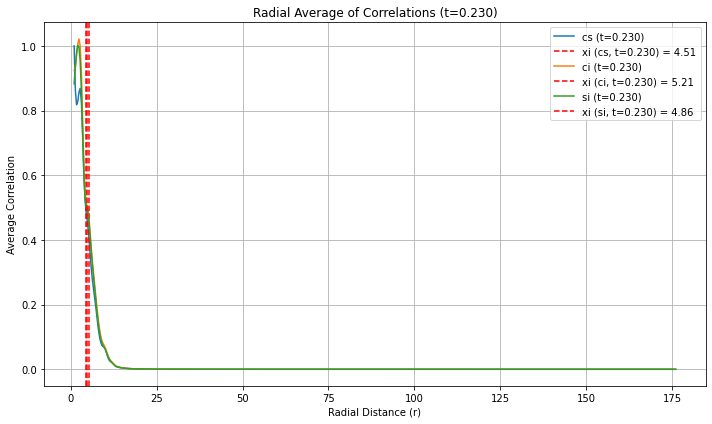

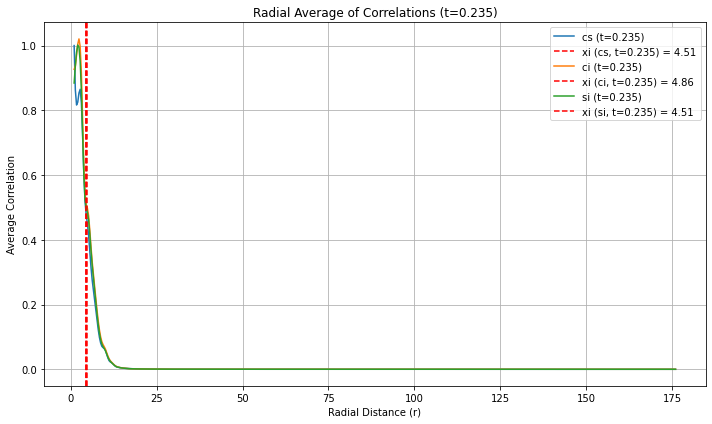

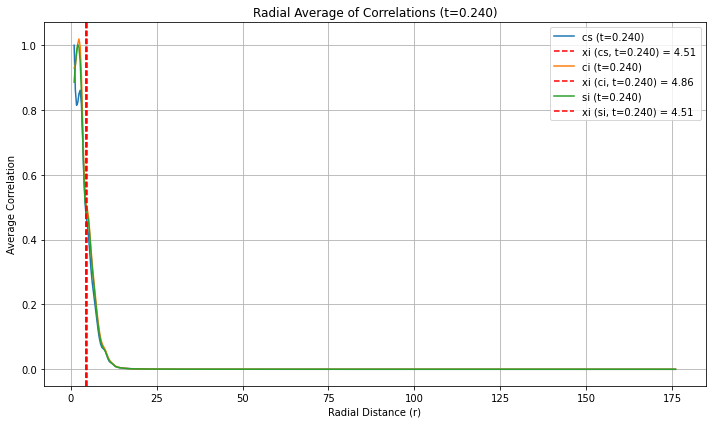

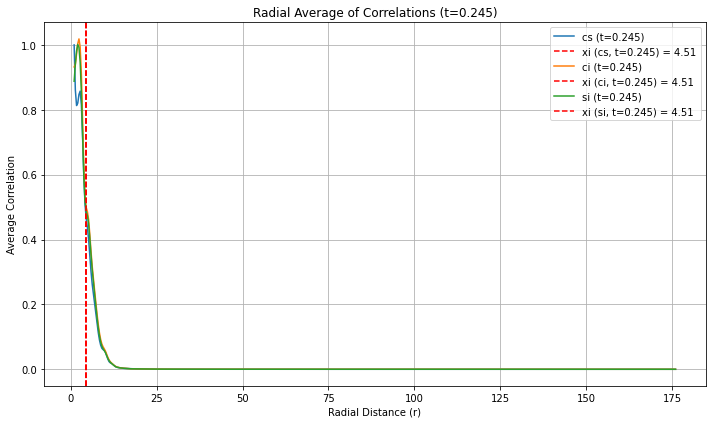

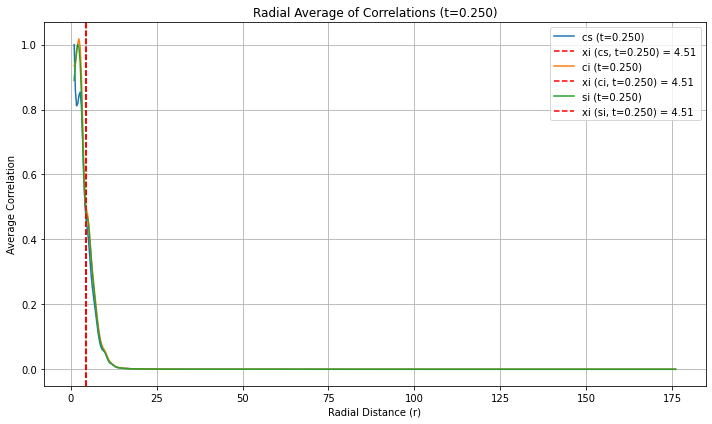

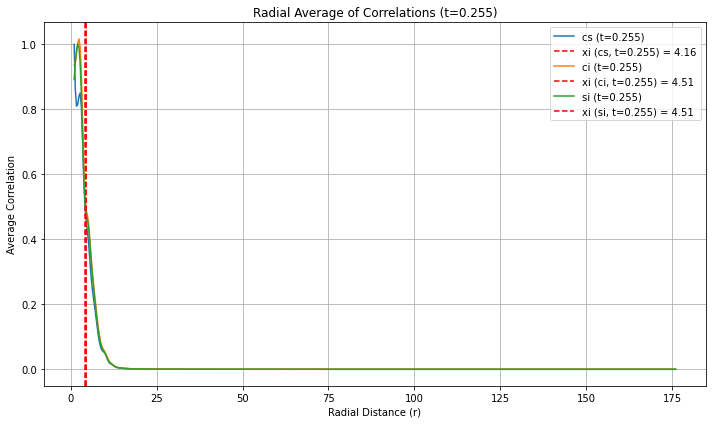

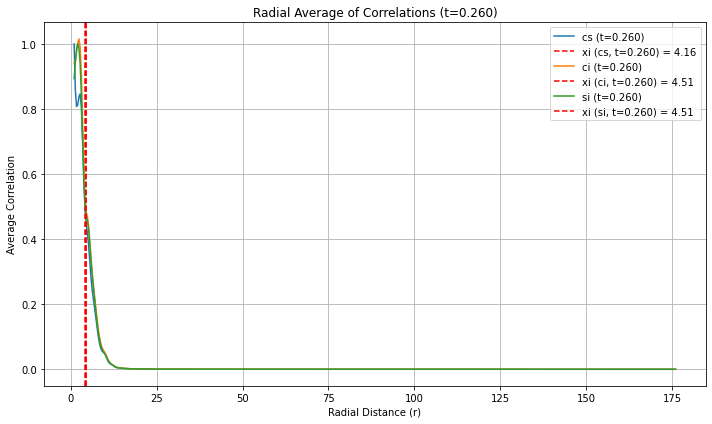

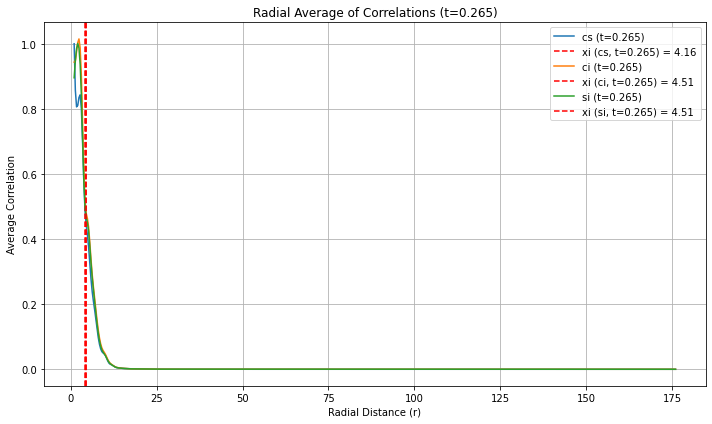

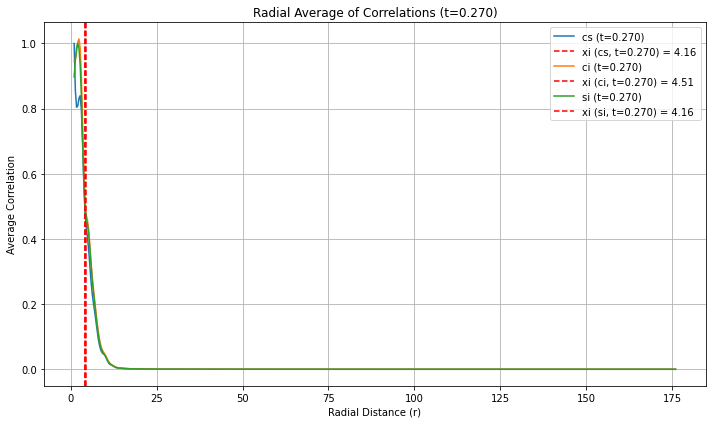

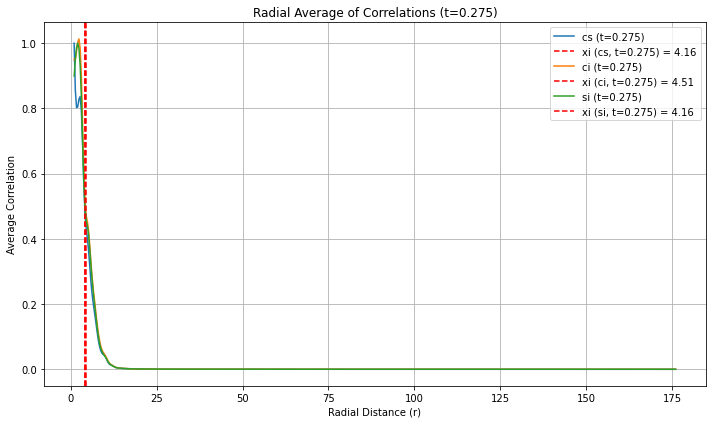

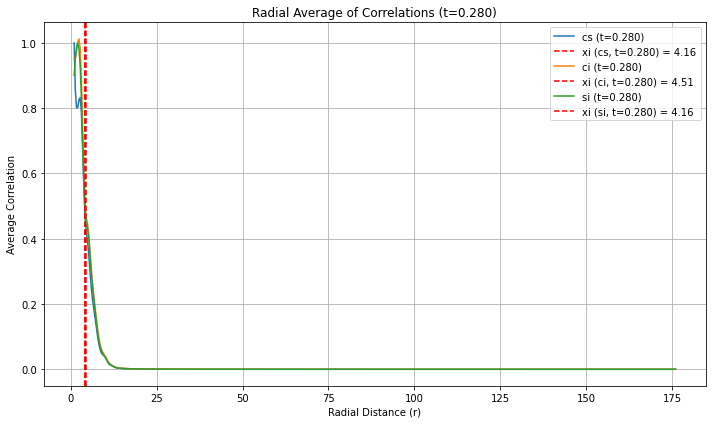

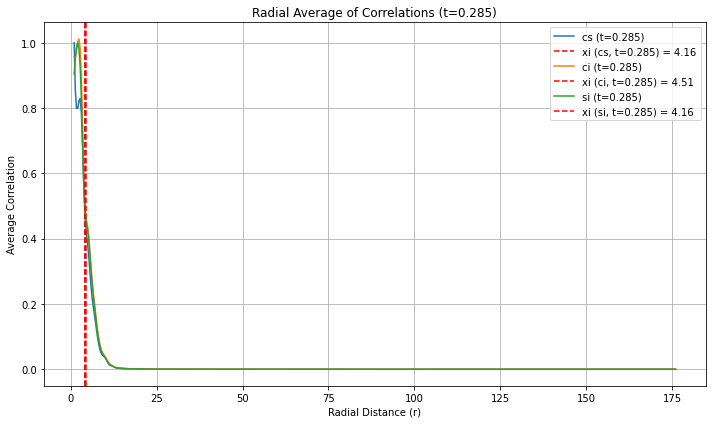

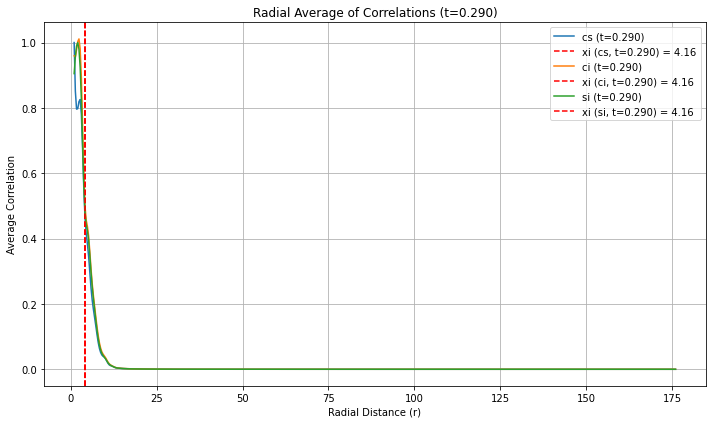

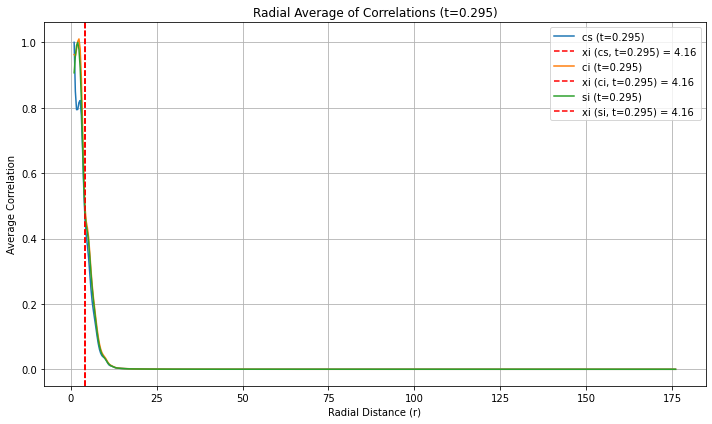

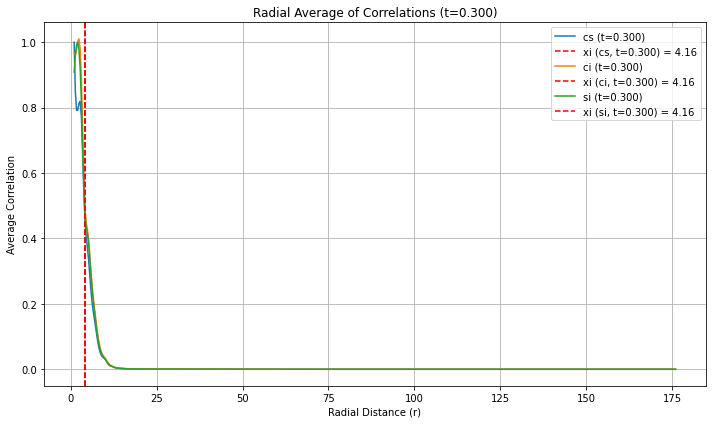

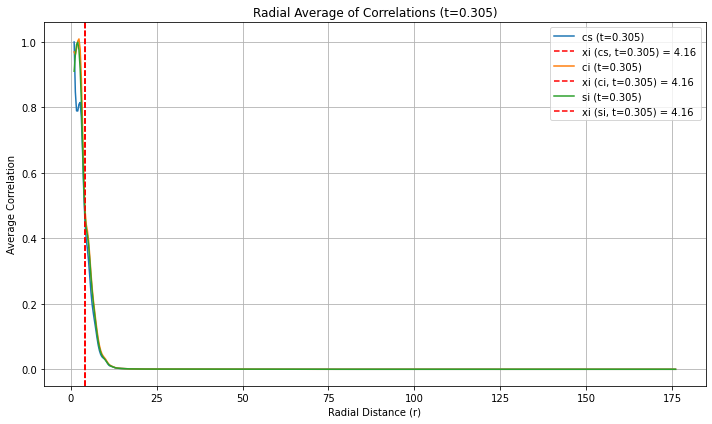

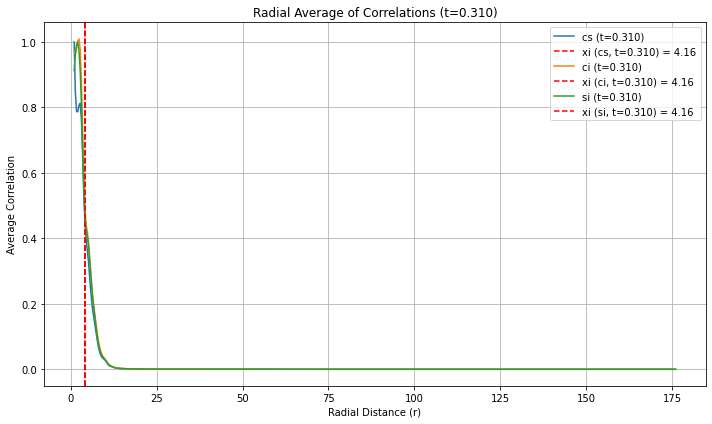

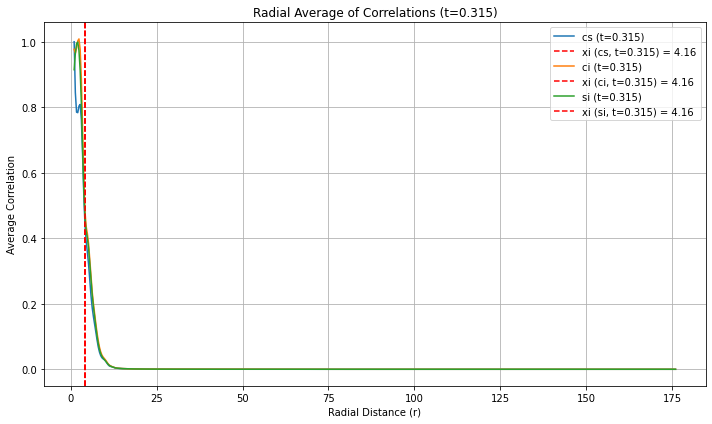

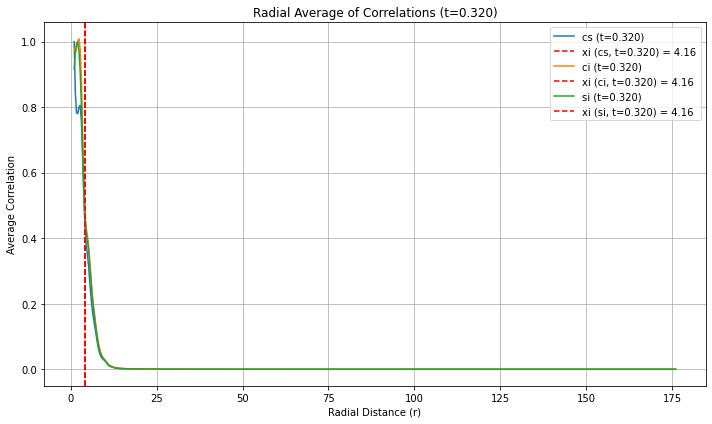

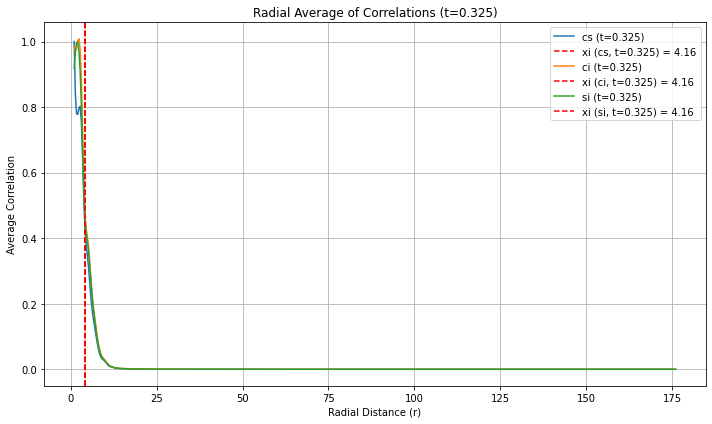

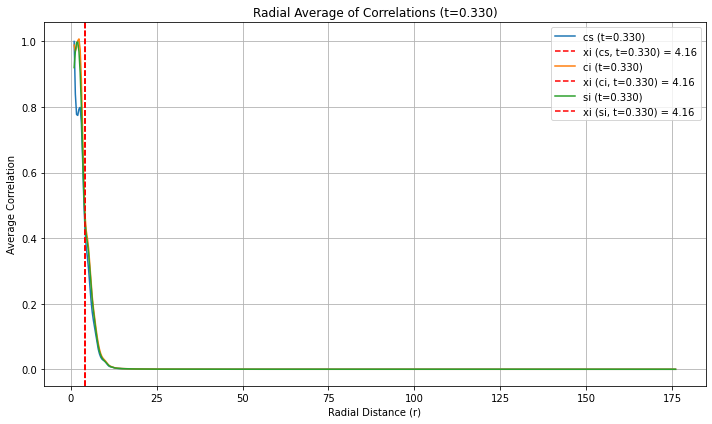

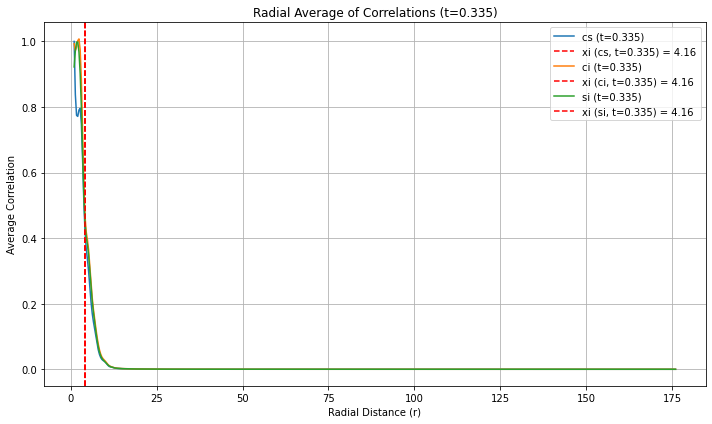

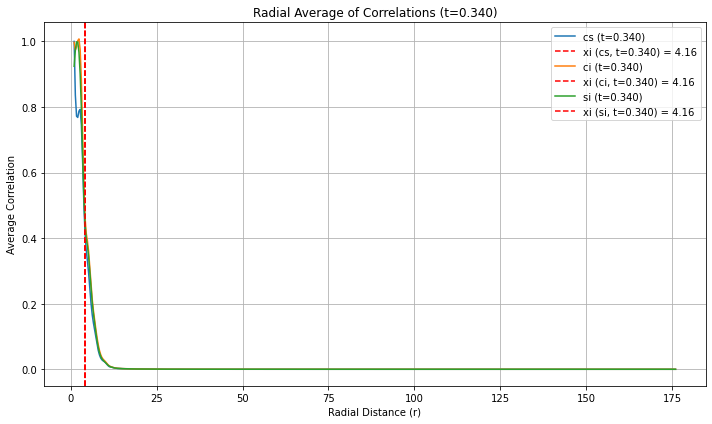

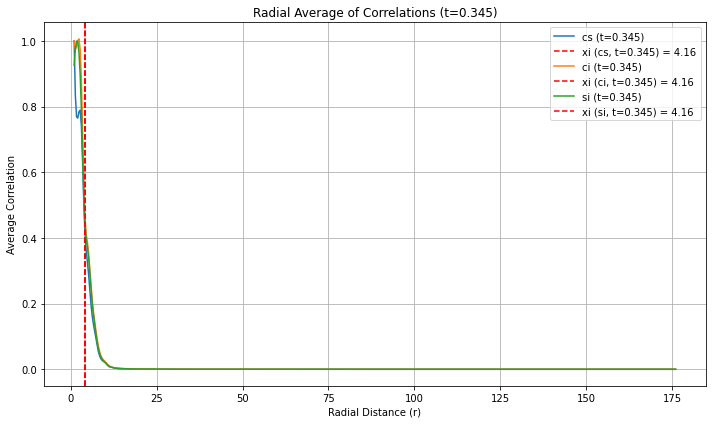

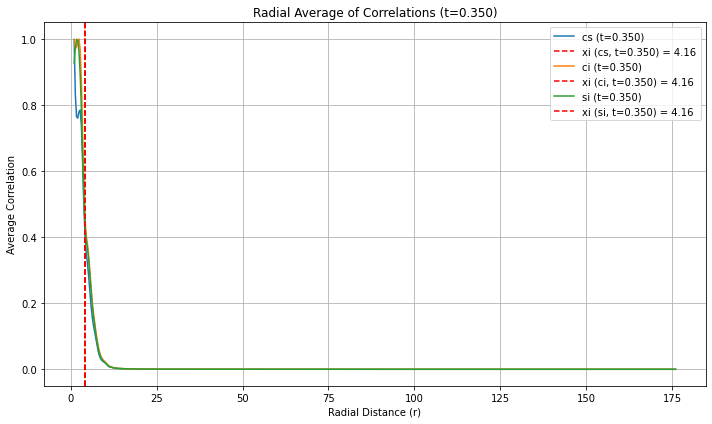

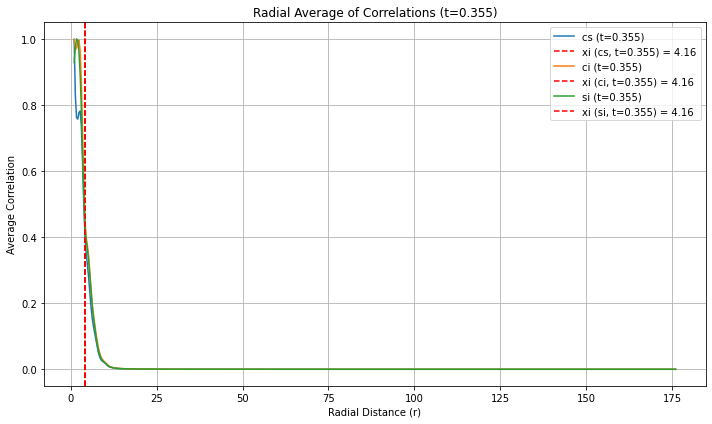

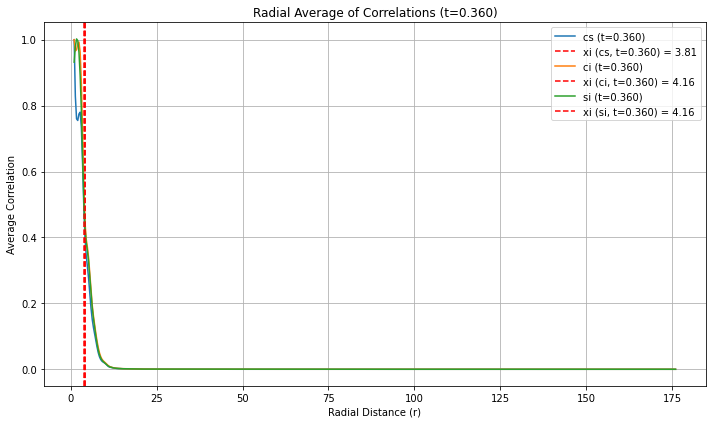

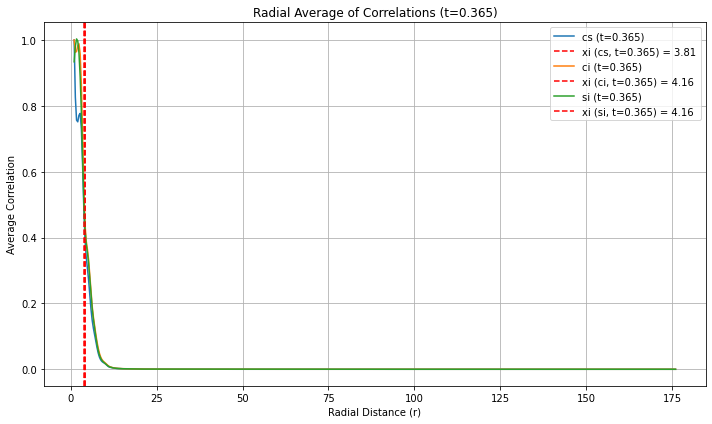

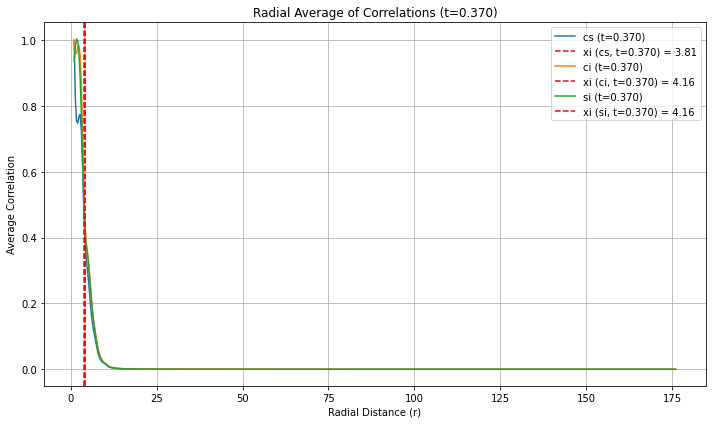

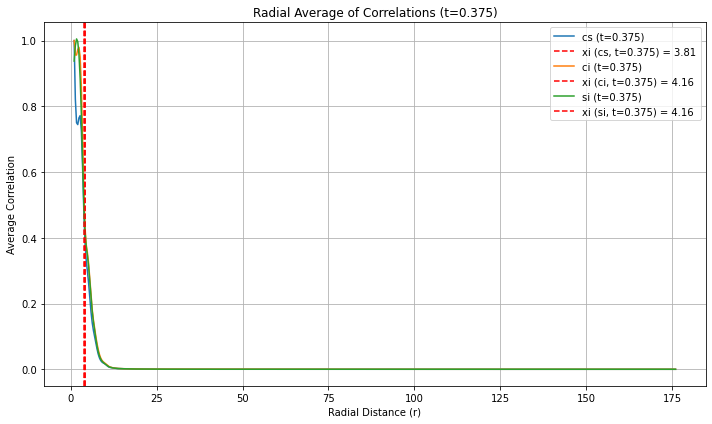

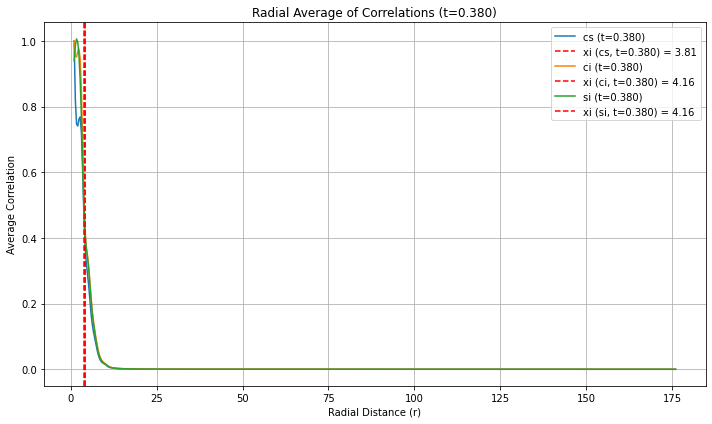

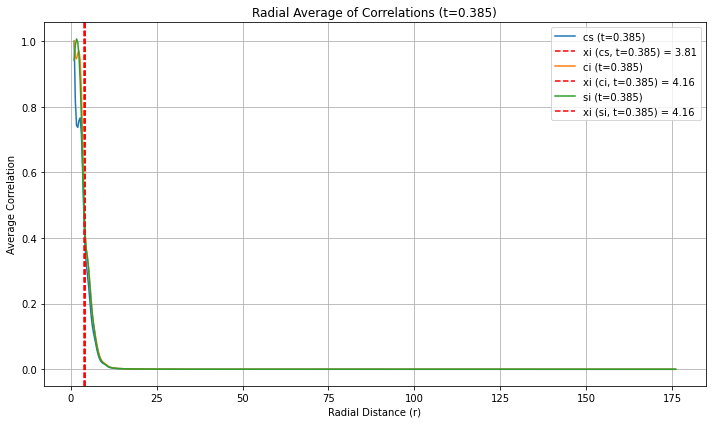

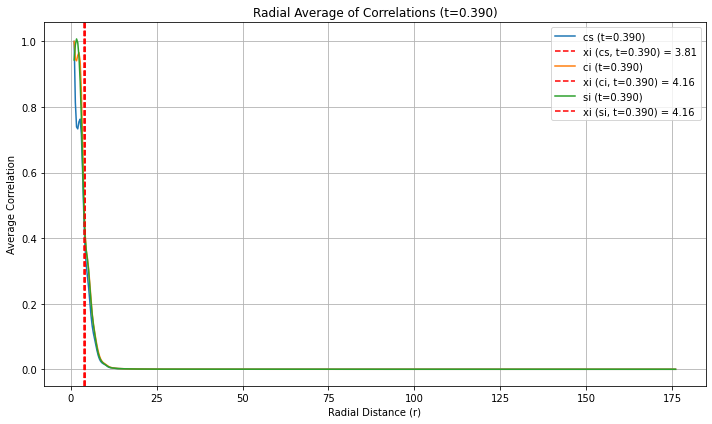

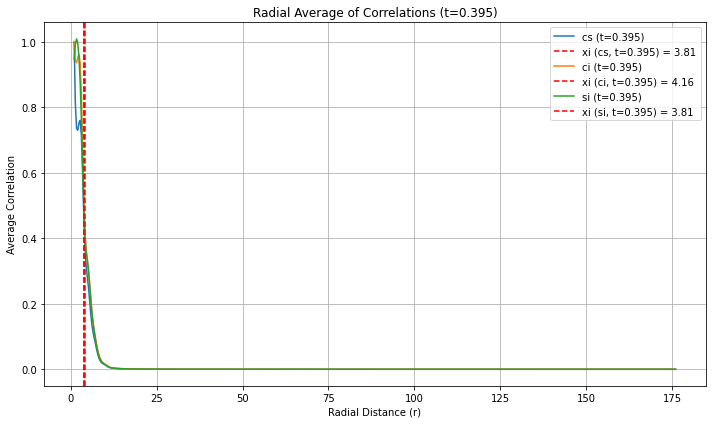

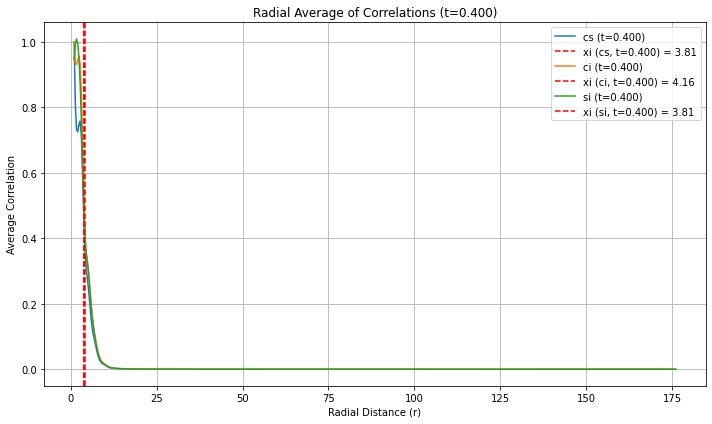

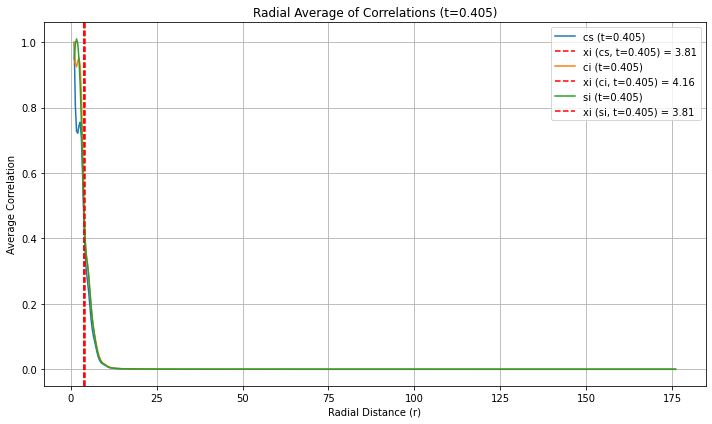

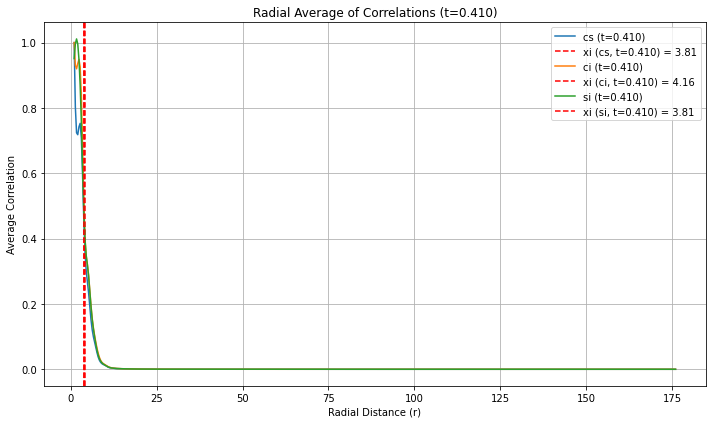

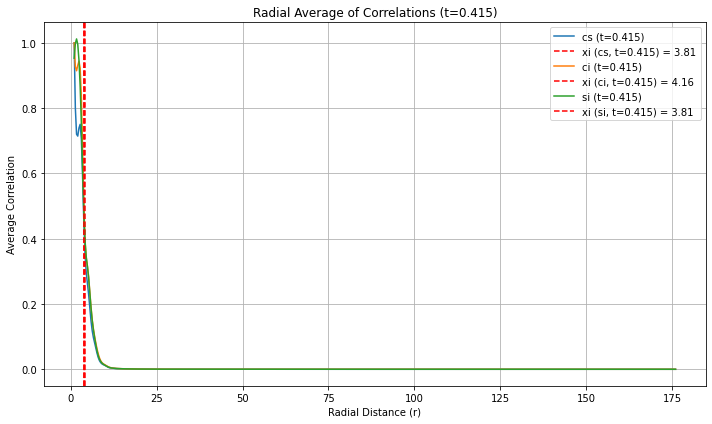

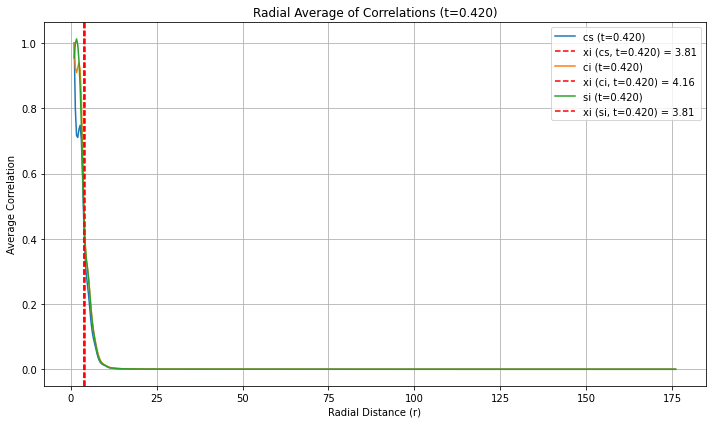

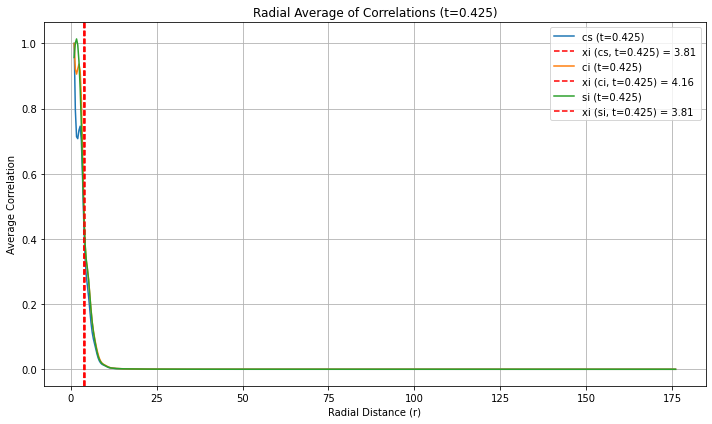

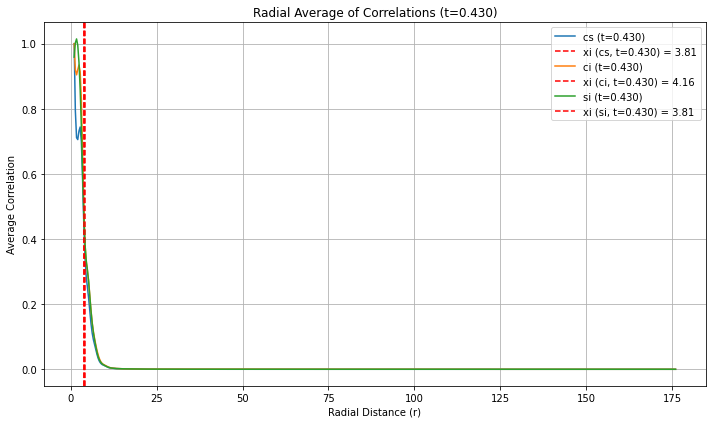

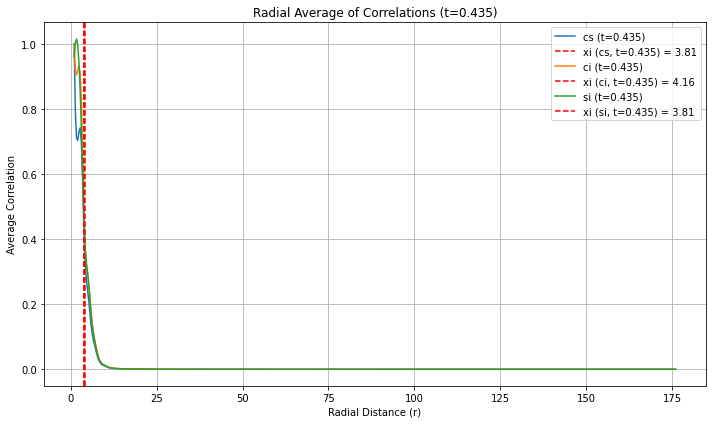

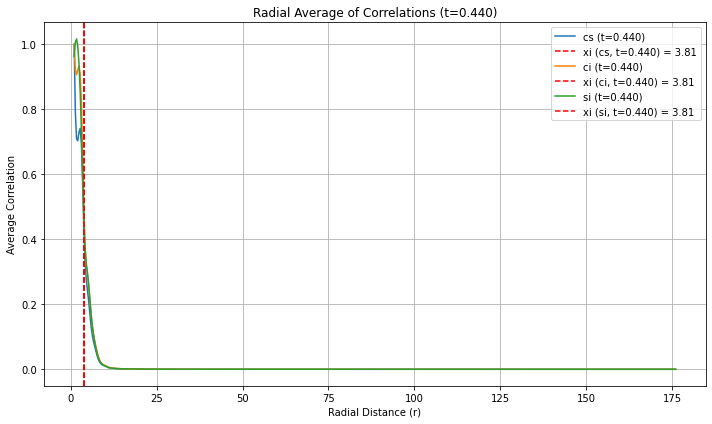

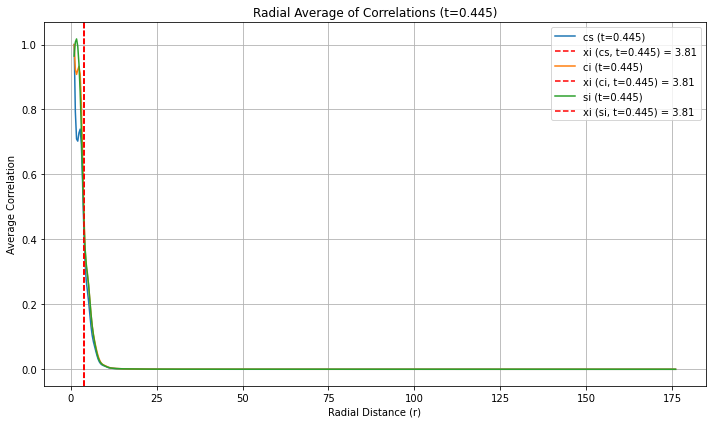

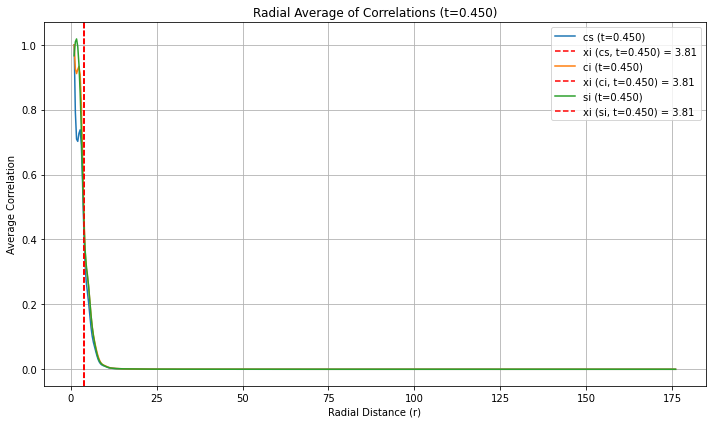

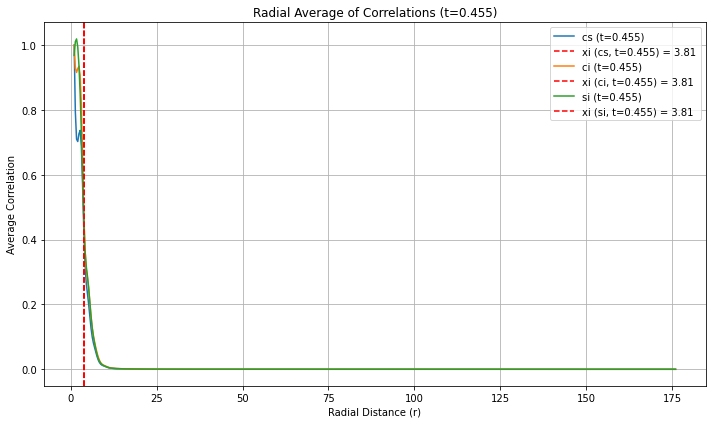

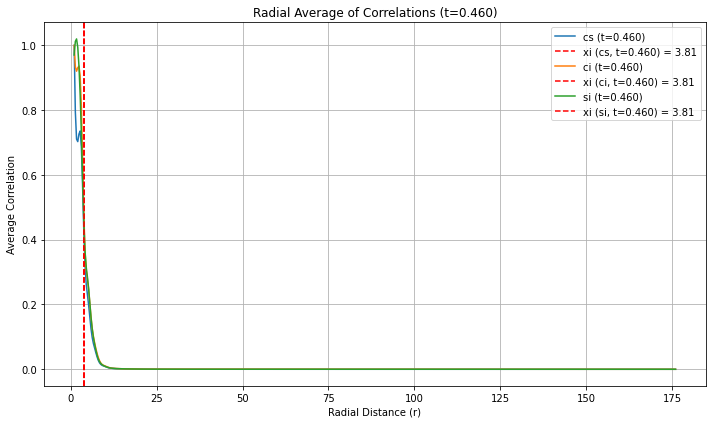

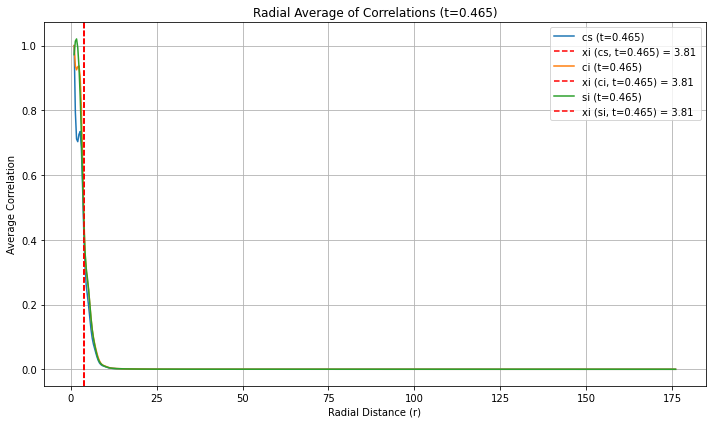

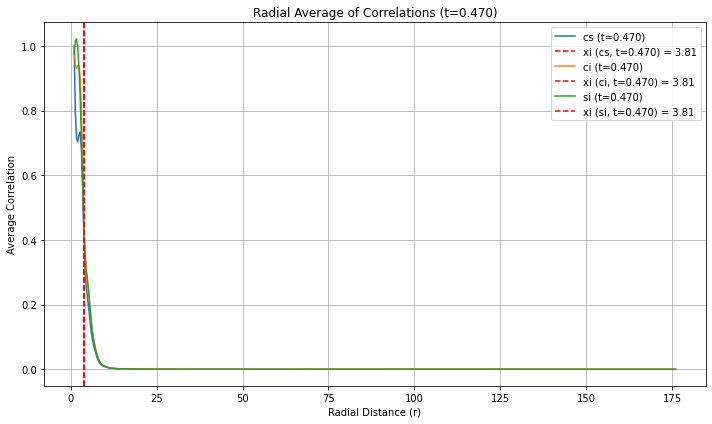

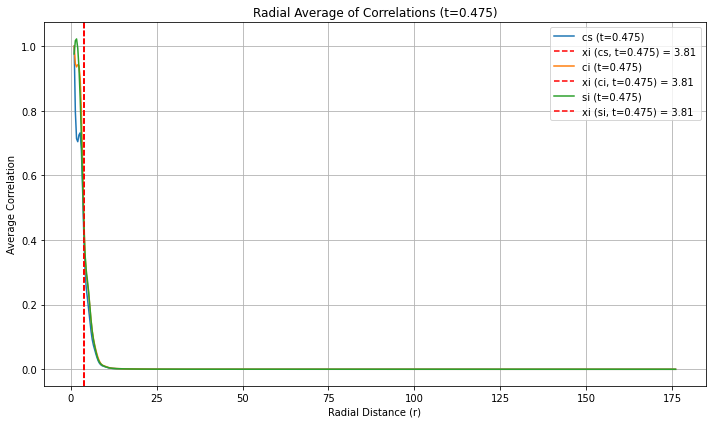

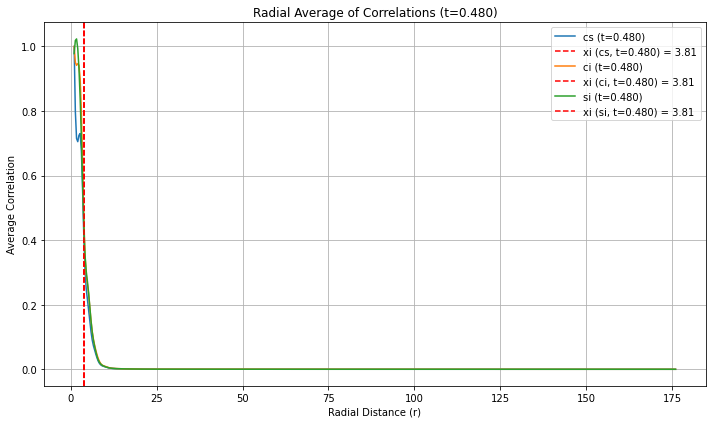

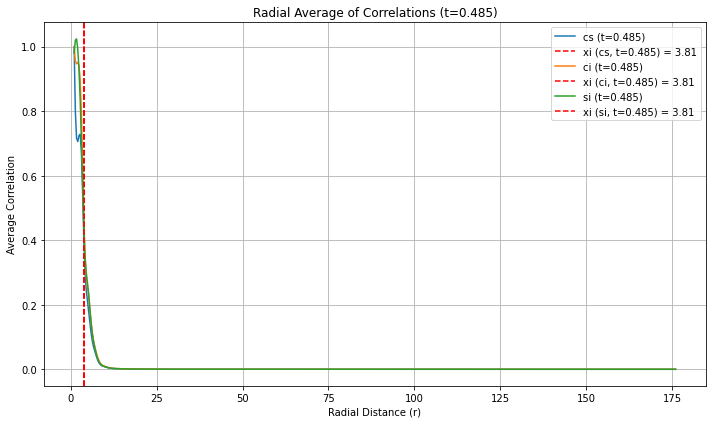

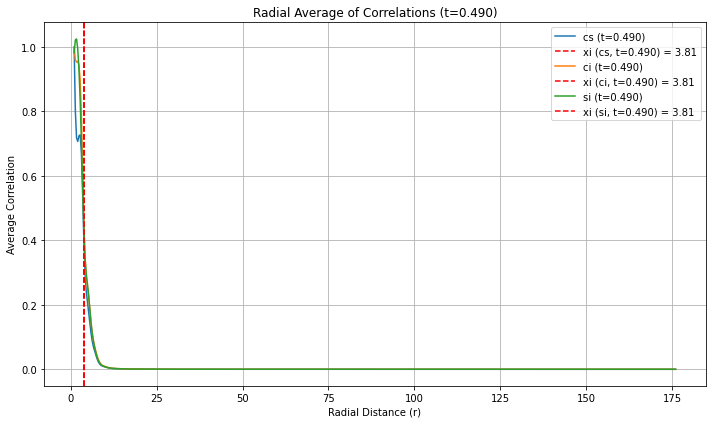

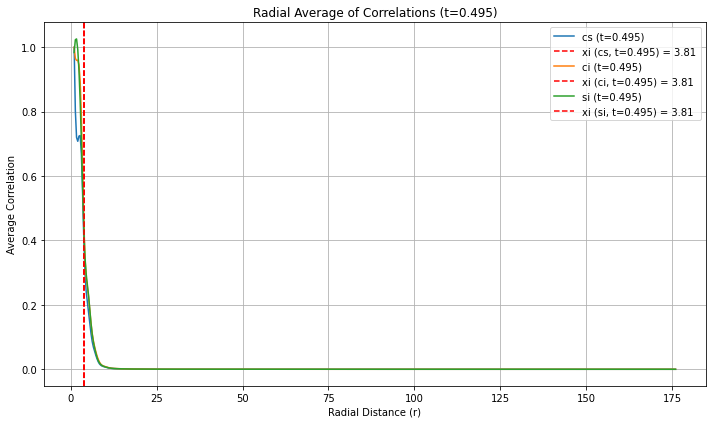

In [36]:
load_and_plot_radial_data(
    start_step=0, 
    end_step=T-dt, 
    dt=dt, 
    corr_types=["cs", "ci", "si"]
)